## Import Libraries

In [2]:
import pandas as pd                                  #import pandas
import numpy as np                                   #import numpy
from numpy import inf                                #import infinity as a value
import glob                                          #for iterating through folders
from sklearn.preprocessing import MinMaxScaler       #Import minmax scaler
from sklearn.decomposition import PCA                #import PCA
import matplotlib.pyplot as plt                      #import plotting library
import tqdm                                          #import progress bar
import pickle                                        #import function to save data as pickles
import chemsy                                        #Import chemsy for some chemometric functions and preprocessing
from chemsy.explore import SupervisedChemsy
from chemsy.prep.methods import *
from chemsy.predict.methods import *
import scipy as sp


## Set Parameters

In [3]:
plt.style.use('ggplot')                             #set ggplot as plotting style
plt.rcParams['axes.facecolor'] = 'white'            #set plot background as white

directory = '/Users/jenniferbonetti/Documents/UvA/Exported Data/'    #Indicate folder location of Data

## Define Functions

In [4]:
def scaling(data_train, data_val, type = "minmax", data_test = None):   #define scaling function
    sc = MinMaxScaler()

    #Minmax scaler assumes data is in different orientation
    new_data_train = pd.DataFrame(sc.fit_transform(data_train.transpose())).transpose()
    new_data_val = pd.DataFrame(sc.fit_transform(data_val.transpose())).transpose()
    
    new_data_train.index = data_train.index  # reset index to original values
    new_data_val.index = data_val.index
    new_data_train.columns = data_train.columns  # reset columns to original values
    new_data_val.columns = data_val.columns
    
    if data_test is not None:
        new_data_test = pd.DataFrame(sc.fit_transform(data_test.transpose())).transpose()
        new_data_test.index = data_test.index
        new_data_test.columns = data_test.columns

        return new_data_train, new_data_val, new_data_test  # return applicable datasets
    else:
        return new_data_train, new_data_val


def baseline(data_train, type = "first_deriv"): 
    #Perform either first or second derivative 

    if type == "first_deriv":
        blc = FirstDerivative()
        new_data_train = blc.fit_transform(data_train)

    if type == "second_deriv":
        blc = SecondDerivative()
        new_data_train = blc.fit_transform(data_train)
    
    new_data_train = pd.DataFrame(new_data_train)
    new_data_train.index = data_train.index

    new_data_train = new_data_train.fillna(0)
    new_data_train[new_data_train==inf] = 0
    new_data_train[new_data_train==-inf] = 0
    return new_data_train

def fingerprint(data):
    #remove wavenumbers higher than 1800
    to_drop = []
    data_fp = data.copy()
    for i in range(0, len(data_fp.columns)):
        if data_fp.columns[i] > 1800: 
            to_drop.append(data_fp.columns[i])
    return data_fp.drop(labels = to_drop, axis = 1)

def scatter(data_train, type = "snv", q=0.15):
    if type == 'snv':
        sc = SNV()
    # Define a new array and populate it with the corrected data
    new_data_train = pd.DataFrame(sc.fit_transform(data_train.transpose())).transpose()

    new_data_train.index = data_train.index  # reset index to original values
    new_data_train = new_data_train.fillna(0)
    new_data_train[new_data_train==inf] = 0
    new_data_train[new_data_train==-inf] = 0
    
    return new_data_train

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data
    x: vector or matrix of data with, say, p columns.
    data: ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed
    cov: covariance matrix (p x p) of the distribution, If none, will be computed"""
    x_minus_mu = x - np.mean(data, axis=0) #calculate x minus the mean of the data
    if not cov: #if the covariance is not provided it will be calculated
        cov = np.cov(data.T) #calculate the covariance of the transposed data matrix
    inv_covmat = sp.linalg.inv(cov) #calculate the inverse of the covariance matrix
    left_term = np.dot(x_minus_mu, inv_covmat) #calculate the left side of the equation: dot product of x minus the class mean, and the inverse of the covariance matrix
    mahal = np.dot(left_term, x_minus_mu.T) #mahalanobix distance is the dot product between the left term and the transpose of x minus the class mean
    if len(x) > 1: #if the length of x is greater than 1, return the diagonal instead of a single value
        return mahal.diagonal()
    else: #if not, return the single value
        return mahal

## Convert/Import APL Dataset

100%|██████████████████████████████████████████| 83/83 [00:00<00:00, 630.40it/s]


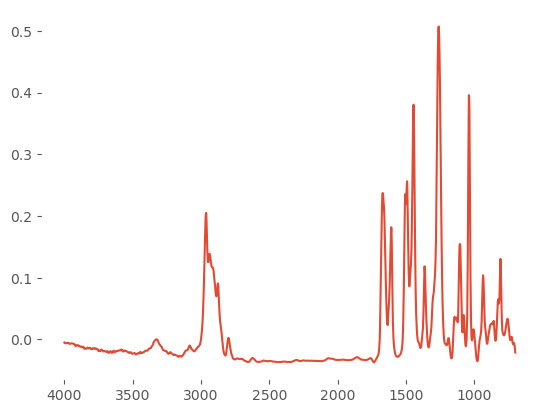

In [5]:
directory_exp = directory + "training-ylones/"        #indicate specific location of Primary Dataset
folders = glob.glob(directory_exp+"/*")               #specify folders

data_dict = {}                                        #create empty dictionary for data
names = []                                            #create empty array
week = []                                             #create empty array for week
for folder in tqdm.tqdm(folders):                     #for each folder
    filename = folder.split("/")[-1]                  #Split folder name at '/' Last segment is the filename
    names.append(filename.split(" ")[0])              #Split filename at " ". First segment is compound name, append to array
    week.append(filename.split(" ")[1][0])            #Split filename at " ". First element of the second segment is week #, append to array
    sample_name = filename.split(".")[0]              #Split filename at "." First element is full sample name
    data_dict[sample_name] = pd.read_csv(folder, header = None)    #Update dictionary with array contained in file, associate with sample name
df_temp = pd.concat(data_dict, axis = 1)              #Convert the dictionary into a dataframe
df_temp.columns = df_temp.columns.droplevel(1)        #Currently, the columns have two levels due to format of files, drop the second (no info)
df_spectra = df_temp.transpose()                      #Transpose the temporary dataframe and save as new name

col_names = []                                        #Create empty array
col_names.append(700)                                 #Begin array at 700 (where APL analysis begins)
for i in range(1,856):                                #APL samples have 856 data points, 
    col_names.append(np.round(700+(i*3.85965), 4))    #Add column names for each wavenumber
df_spectra.columns = col_names                        #Make the dataframe column names into the array just filled in

new_col_names = []                                    #Create empty array for new column names
new_col_names.append(700)                             #Append first column value, analysis starts at 700
for i in range(1,1651):                               #Fill in column names, data point spacing is 2
    new_col_names.append(700+(i*2))

new_df_spectra = pd.DataFrame(0, columns = new_col_names, index = df_spectra.index, dtype = 'float64') #Create empty dataframe with new column names

for j in range(0, new_df_spectra.shape[0]):        #For each row in dataframe
    new_df_spectra.iloc[j,:] = np.interp(new_df_spectra.columns, df_spectra.columns, df_spectra.iloc[j,:]) #interpolate values to match new column names

new_df_spectra['label'] = names                           #Create new column with the compound names
new_df_spectra['week'] = week                             #Create new column with the analysis week


new_df_spectra.to_pickle("df_spectra.pkl")                #Save as a pickle
# new_df_spectra.to_excel('APL_interpolated.xlsx')

plt.plot(new_df_spectra.iloc[0,0:1651])                    #Plot first spectrum
plt.gca().invert_xaxis()
plt.show()

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 376.30it/s]


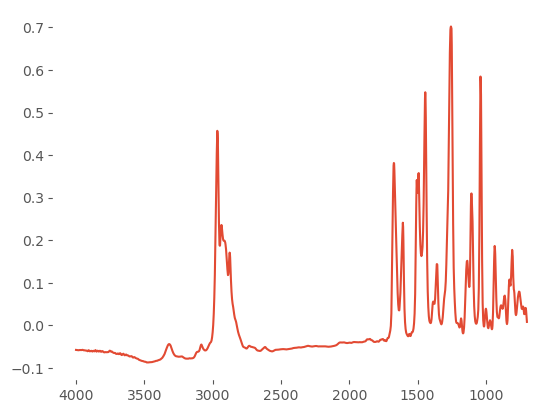

In [6]:
#APL Base extracted samples

directory_exp = directory + "Test_base/"    #indicate specific location of APL Case Samples/Library Spectra (base extracted)

folders = glob.glob(directory_exp+"/*")               #specify folders

data_dict = {}                                        #create empty dictionary for data
names = []                                            #create empty array
week = []                                             #create empty array for week
for folder in tqdm.tqdm(folders):                     #for each folder
    filename = folder.split("/")[-1]                  #Split folder name at '/' Last segment is the filename
    new_filename = filename.split(".")[0]             #Split filename at "." First element is compound name (with extra letters)
    size = len(new_filename)                          #Calculate length of new filename
    names.append(new_filename[:size - 2])             #Actual compound name is two characters shorter  
    data_dict[new_filename] = pd.read_csv(folder, header = None)    #Update dictionary with array contained in file, associate with sample name
df_temp_apl = pd.concat(data_dict, axis = 1)              #Convert the dictionary into a dataframe
df_temp_apl.columns = df_temp_apl.columns.droplevel(1)        #Currently, the columns have two levels due to format of files, drop the second (no info)
df_spectra_apl = df_temp_apl.transpose()                      #Transpose the temporary dataframe and save as new name

col_names = []                                        #Create empty array
col_names.append(700)                                 #Begin array at 700 (where APL analysis begins)
for i in range(1,856):                                #APL samples have 856 data points, 
    col_names.append(np.round(700+(i*3.85965), 4))    #Add column names for each wavenumber
# col_names.append('label')                             #Add column name for label
df_spectra_apl.columns = col_names                        #Make the dataframe column names into the array just filled in

new_col_names = []                                         #Create empty array for new column names
new_col_names.append(700)                                  #Append first column value, analysis starts at 700
for i in range(1,1651):                                #Fill in column names, data point spacing is 2
    new_col_names.append(700+(i*2))

new_df_spectra_apl = pd.DataFrame(0, columns = new_col_names, index = df_spectra_apl.index, dtype = 'float64') #Create empty dataframe with new column names

for j in range(0, new_df_spectra_apl.shape[0]):        #For each row in dataframe
    new_df_spectra_apl.iloc[j,:] = np.interp(new_df_spectra_apl.columns, df_spectra_apl.columns, df_spectra_apl.iloc[j,:]) #interpolate values to match new column names

new_df_spectra_apl['label'] = names                           #Create new column with the compound names

new_df_spectra_apl.to_pickle("df_test_apl-base.pkl")                #Save as a pickle


plt.plot(new_df_spectra_apl.iloc[0,0:1651])                    #Plot first spectrum
plt.gca().invert_xaxis()
plt.show()

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 220.60it/s]


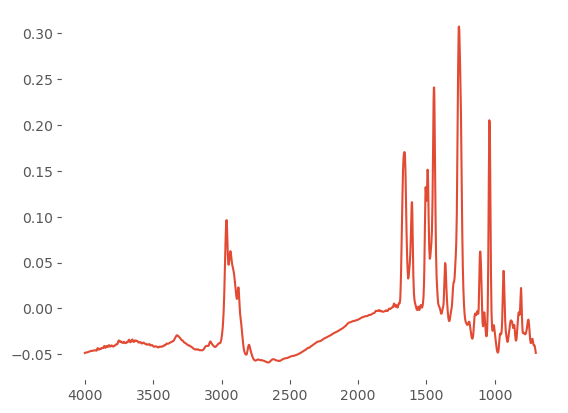

In [7]:
#APL MeOH Samples
directory_exp = directory + "Test_MeOH/"    #indicate specific location of APL Case Samples/Library Spectra

folders = glob.glob(directory_exp+"/*")               #specify folders

data_dict = {}                                        #create empty dictionary for data
names = []                                            #create empty array
week = []                                             #create empty array for week
for folder in tqdm.tqdm(folders):                     #for each folder
    filename = folder.split("/")[-1]                  #Split folder name at '/' Last segment is the filename
    new_filename = filename.split(".")[0]             #Split filename at "." First element is compound name (with extra letters)
    size = len(new_filename)                          #Calculate length of new filename
    names.append(filename.split(" ")[0])             #Actual compound name is two characters shorter  
    data_dict[new_filename] = pd.read_csv(folder, header = None)    #Update dictionary with array contained in file, associate with sample name
df_temp_apl = pd.concat(data_dict, axis = 1)              #Convert the dictionary into a dataframe
df_temp_apl.columns = df_temp_apl.columns.droplevel(1)        #Currently, the columns have two levels due to format of files, drop the second (no info)
df_spectra_apl = df_temp_apl.transpose()                      #Transpose the temporary dataframe and save as new name

col_names = []                                        #Create empty array
col_names.append(700)                                 #Begin array at 700 (where APL analysis begins)
for i in range(1,856):                                #APL samples have 856 data points, 
    col_names.append(np.round(700+(i*3.85965), 4))    #Add column names for each wavenumber
df_spectra_apl.columns = col_names                        #Make the dataframe column names into the array just filled in

new_col_names = []                                         #Create empty array for new column names
new_col_names.append(700)                                  #Append first column value, analysis starts at 700
for i in range(1,1651):                                #Fill in column names, data point spacing is 2
    new_col_names.append(700+(i*2))

new_df_spectra_apl = pd.DataFrame(0, columns = new_col_names, index = df_spectra_apl.index, dtype = 'float64') #Create empty dataframe with new column names

for j in range(0, new_df_spectra_apl.shape[0]):        #For each row in dataframe
    new_df_spectra_apl.iloc[j,:] = np.interp(new_df_spectra_apl.columns, df_spectra_apl.columns, df_spectra_apl.iloc[j,:]) #interpolate values to match new column names

new_df_spectra_apl['label'] = names                           #Create new column with the compound names

new_df_spectra_apl.to_pickle("df_test_apl-meoh.pkl")                #Save as a pickle

plt.plot(new_df_spectra_apl.iloc[0,0:1651])                    #Plot first spectrum
plt.gca().invert_xaxis()
plt.show()

## Import DFS Test Data

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 491.69it/s]


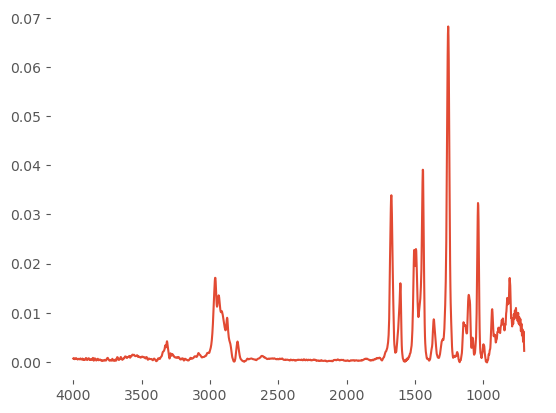

In [8]:
# DFS Base extracted samples
directory_exp = directory + "Test_DFS_base"          #indicate specific location of DFS Dataset

folders = glob.glob(directory_exp+"/*")                #Specify folders

data_dict = {}                                         #Create empty dictionary
names = []                                             #Create empty array
for folder in tqdm.tqdm(folders):                      #For each folder in directory
    filename = folder.split("/")[-1]                   #Split folder name by "/", Last element is filename
    names.append(filename.split(" ")[0])               #Split filename by " ". First element is compound name
    sample_name = filename.split(".")[0]               #Split filename by "." First element is sample name
    data_dict[sample_name] = pd.read_csv(folder, header = None) #Update dictionary with array contained in file, associate with sample name
df_temp_dfs = pd.concat(data_dict, axis = 1)           #Convert dictionary into dataframe
df_temp_dfs.columns = df_temp_dfs.columns.droplevel(1) #Currently, the columns have two levels due to format of files, drop the second (no info)
df_spectra_dfs = df_temp_dfs.transpose()               #Transpose temporary dataframe and save as new name
df_spectra_dfs = df_spectra_dfs.iloc[:,::-1]           #Invert dataframe so spectra will be aligned (ie. 700-4000 vs 4000-700)

col_names = []                                         #Create empty array
col_names.append(680)                                  #Append first column value, analysis starts at 680
for i in range(1,1661):                                #Fill in column names, data point spacing is 2
    col_names.append(680+(i*2))

df_spectra_dfs.columns = col_names                     #Make columns names into array created

drop_columns = range(680,700,2)                        #Drop columns that are extraneous (ie. don't appear in APL spectra)
for i in drop_columns:
    df_spectra_dfs = df_spectra_dfs.drop(i, axis = 1)

df_spectra_dfs['label'] = names                    #Make label column with compound names
df_spectra_dfs.to_pickle("df_test_dfs-base.pkl")        #Save as pickle

plt.plot(df_spectra_dfs.iloc[0,0:1651])             #Plot first spectrum
plt.gca().invert_xaxis()
plt.show()

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 546.75it/s]


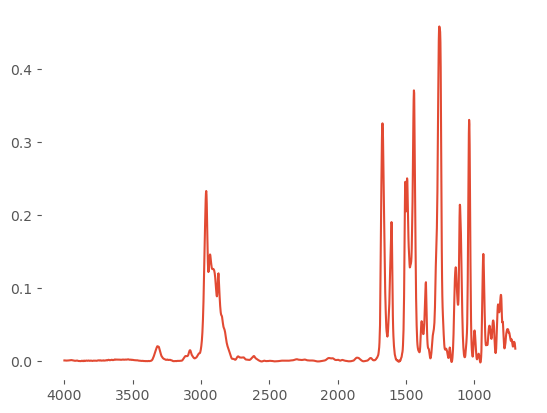

In [9]:
# DFS Methanol Samples
directory_exp = directory + "Test_DFS_MeOH"          #indicate specific location of DFS Dataset

folders = glob.glob(directory_exp+"/*")                #Specify folders

data_dict = {}                                         #Create empty dictionary
names = []                                             #Create empty array
for folder in tqdm.tqdm(folders):                      #For each folder in directory
    filename = folder.split("/")[-1]                   #Split folder name by "/", Last element is filename
    names.append(filename.split(" ")[0])               #Split filename by " ". First element is compound name
    sample_name = filename.split(".")[0]               #Split filename by "." First element is sample name
    data_dict[sample_name] = pd.read_csv(folder, header = None) #Update dictionary with array contained in file, associate with sample name
df_temp_dfs = pd.concat(data_dict, axis = 1)           #Convert dictionary into dataframe
df_temp_dfs.columns = df_temp_dfs.columns.droplevel(1) #Currently, the columns have two levels due to format of files, drop the second (no info)
df_spectra_dfs = df_temp_dfs.transpose()               #Transpose temporary dataframe and save as new name
df_spectra_dfs = df_spectra_dfs.iloc[:,::-1]           #Invert dataframe so spectra will be aligned (ie. 700-4000 vs 4000-700)

col_names = []                                         #Create empty array
col_names.append(680)                                  #Append first column value, analysis starts at 680
for i in range(1,1661):                                #Fill in column names, data point spacing is 2
    col_names.append(680+(i*2))

df_spectra_dfs.columns = col_names                     #Make columns names into array created

drop_columns = range(680,700,2)                        #Drop columns that are extraneous (ie. don't appear in APL spectra)
for i in drop_columns:
    df_spectra_dfs = df_spectra_dfs.drop(i, axis = 1)

df_spectra_dfs['label'] = names                    #Make label column with compound names
df_spectra_dfs.to_pickle("df_test_dfs-meoh.pkl")        #Save as pickle

plt.plot(df_spectra_dfs.iloc[0,0:1651])             #Plot first spectrum
plt.gca().invert_xaxis()
plt.show()

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 593.01it/s]


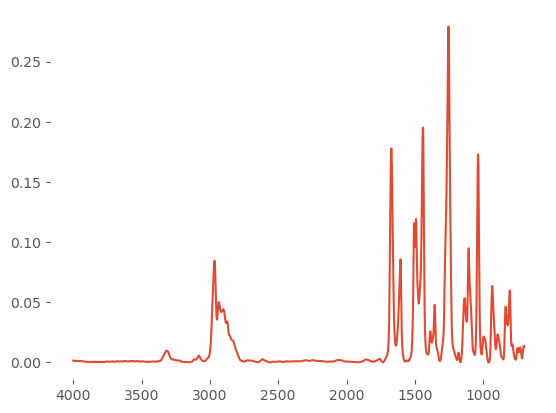

In [10]:
#DFS "Other" cathinones
directory_exp = directory + "Test_DFS_Other_ylones"    #indicate specific location of "Others"

folders = glob.glob(directory_exp+"/*")                #Specify folders

data_dict = {}                                         #Create empty dictionary
names = []                                             #Create empty array
for folder in tqdm.tqdm(folders):                      #For each folder in directory
    filename = folder.split("/")[-1]                   #Split folder name by "/", Last element is filename
    names.append(filename.split(" ")[0])               #Split filename by " ". First element is compound name
    sample_name = filename.split(".")[0]               #Split filename by "." First element is sample name
    data_dict[sample_name] = pd.read_csv(folder, header = None) #Update dictionary with array contained in file, associate with sample name
df_temp_dfs = pd.concat(data_dict, axis = 1)           #Convert dictionary into dataframe
df_temp_dfs.columns = df_temp_dfs.columns.droplevel(1) #Currently, the columns have two levels due to format of files, drop the second (no info)
df_spectra_dfs = df_temp_dfs.transpose()               #Transpose temporary dataframe and save as new name
df_spectra_dfs = df_spectra_dfs.iloc[:,::-1]           #Invert dataframe so spectra will be aligned (ie. 700-4000 vs 4000-700)

col_names = []                                         #Create empty array
col_names.append(680)                                  #Append first column value, analysis starts at 680
for i in range(1,1661):                                #Fill in column names, data point spacing is 2
    col_names.append(680+(i*2))

df_spectra_dfs.columns = col_names                     #Make columns names into array created

drop_columns = range(680,700,2)                        #Drop columns that are extraneous (ie. don't appear in APL spectra)
for i in drop_columns:
    df_spectra_dfs = df_spectra_dfs.drop(i, axis = 1)

df_spectra_dfs['label'] = names                    #Make label column with compound names

df_spectra_dfs.to_pickle("df_test_dfs_other.pkl")        #Save as pickle

plt.plot(df_spectra_dfs.iloc[0,0:1651])             #Plot first spectrum
plt.gca().invert_xaxis()
plt.show()

## Scale data and save data and label vectors

In [11]:
df_spectra = pd.read_pickle("df_spectra.pkl")        #Load Primary dataset

val_week1 = 2
val_week2 = 3                    #Select random week (Week 1 data was exploratory, weeks 2-4 used, described as 1-3 in publication)
val_week3 = 4

df_train = df_spectra[df_spectra['week'].astype(int)==val_week1]  #Set training data as week 1
df_val1 = df_spectra[df_spectra['week'].astype(int)==val_week2]    #Set val data as week 3 (2 in pub)
df_val2 = df_spectra[df_spectra['week'].astype(int)==val_week3]    #Set val data as week 4 (3 in pub)

data_train = df_train.drop(labels=["label", "week"], axis = 1)   #isolate training data from labels/week info
label_train = df_train["label"]                                  #isolate label info for training

data_val1 = df_val1.drop(labels=["label", "week"], axis = 1)       #isolate validation data
label_val1 = df_val1["label"]                                      #isolate label info for validation

data_val2 = df_val2.drop(labels=["label", "week"], axis = 1)       #isolate validation data
label_val2 = df_val2["label"]                                      #isolate label info for validation

df_test_base = pd.read_pickle("df_test_apl-base.pkl")            #Load APL test data - base
data_test_base = df_test_base.drop(labels="label", axis = 1)     #isolate data
label_test_base = df_test_base["label"]                          #isolate label info

df_test_meoh = pd.read_pickle("df_test_apl-meoh.pkl")            #Load APL test data - meoh
data_test_meoh = df_test_meoh.drop(labels="label", axis = 1)     #isolate data
label_test_meoh = df_test_meoh["label"]                          #isolate label info

df_dfs_base = pd.read_pickle("df_test_dfs-base.pkl")             #Load DFS test data - base
data_dfs_base = df_dfs_base.drop(labels="label", axis = 1)       #isolate data
label_dfs_base = df_dfs_base["label"]                            #isolate label info

df_dfs_meoh = pd.read_pickle("df_test_dfs-meoh.pkl")             #Load DFS test data - meoh
data_dfs_meoh = df_dfs_meoh.drop(labels="label", axis = 1)       #isolate data
label_dfs_meoh = df_dfs_meoh["label"]                            #isolate label info

df_other = pd.read_pickle("df_test_dfs_other.pkl")     #Load "Other" DFS Data
data_other = df_other.drop(labels="label", axis = 1)   #isolate data
label_other = df_other["label"]                        #isolate label info

data_train, data_val1, data_test_base = scaling(data_train, data_val1, type = "minmax", data_test = data_test_base)  #Perform Minmax scaling
data_dfs_base, data_dfs_meoh, data_test_meoh = scaling(data_dfs_base, data_dfs_meoh, type = "minmax", data_test = data_test_meoh)
data_other, data_val2 = scaling(data_other, data_val2, type = "minmax")

data_primary = pd.concat((data_train, data_val1, data_val2), axis = 0)  #Create primary dataset (minmax scaled)
label_primary = pd.concat((label_train, label_val1, label_val2))

#Save data and label to pickles
data_primary.to_pickle("data_primary.pkl")
data_train.to_pickle("data_train.pkl")
data_test_base.to_pickle("data_test_base.pkl")
data_test_meoh.to_pickle("data_test_meoh.pkl")
data_val1.to_pickle("data_val1.pkl")
data_val2.to_pickle("data_val2.pkl")
data_dfs_base.to_pickle("data_dfs_base.pkl")
data_dfs_meoh.to_pickle("data_dfs_meoh.pkl")
data_other.to_pickle("data_other.pkl")

label_primary.to_pickle("label_primary.pkl")
label_train.to_pickle("label_train.pkl")
label_test_base.to_pickle("label_test_base.pkl")
label_test_meoh.to_pickle("label_test_meoh.pkl")
label_val1.to_pickle("label_val1.pkl")
label_val2.to_pickle("label_val2.pkl")
label_dfs_base.to_pickle("label_dfs_base.pkl")
label_dfs_meoh.to_pickle("label_dfs_meoh.pkl")
label_other.to_pickle("label_other.pkl")

## Plot APL Training Dataset

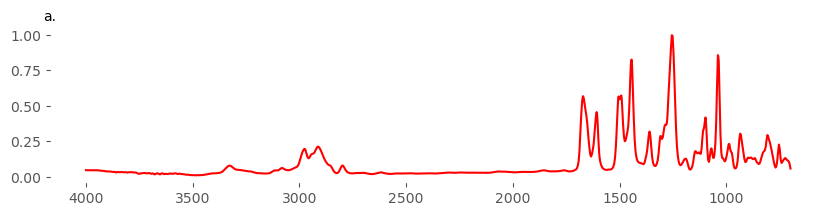

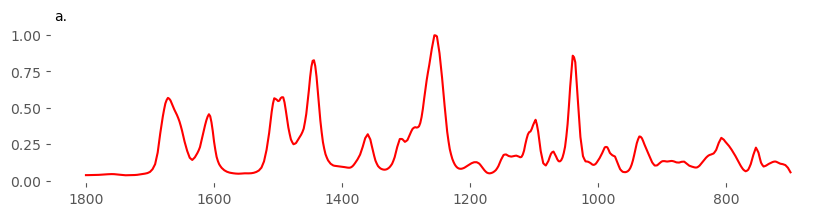

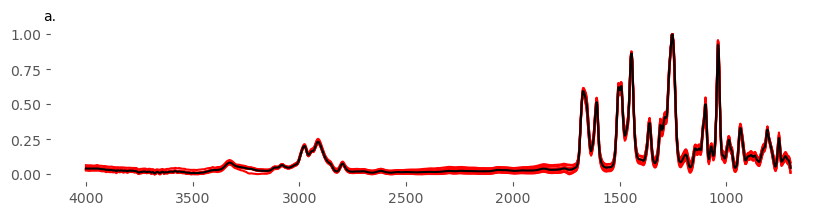

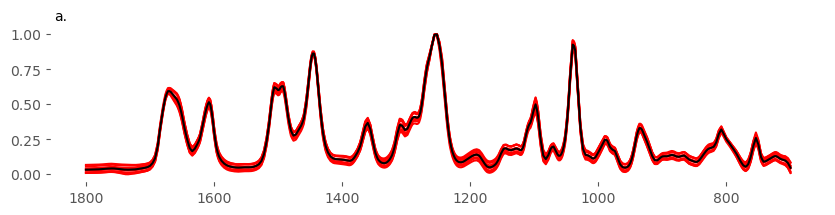

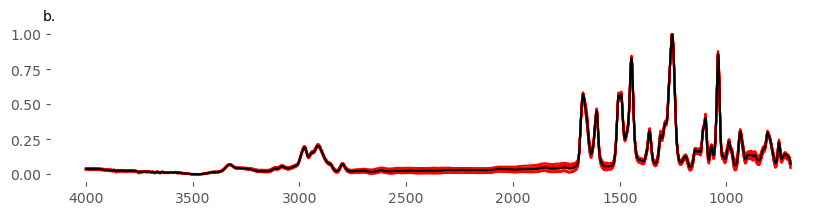

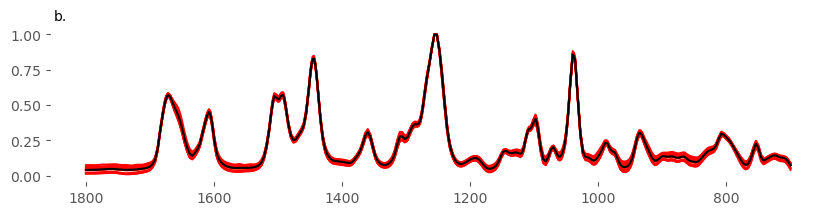

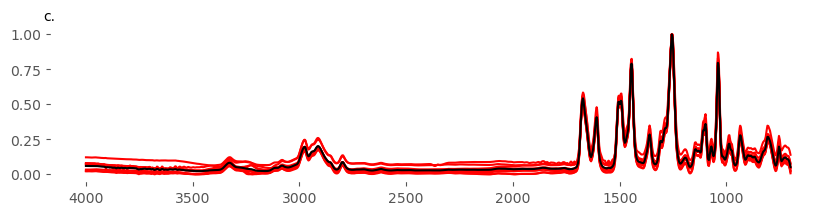

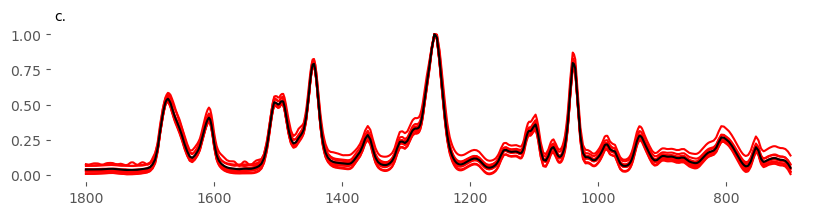

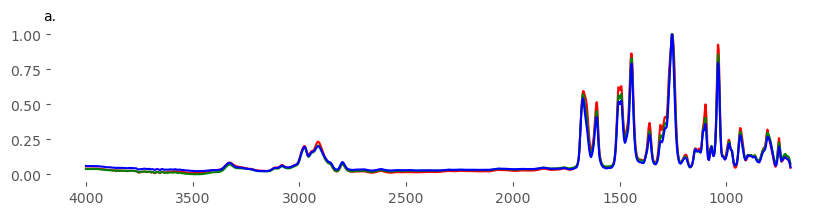

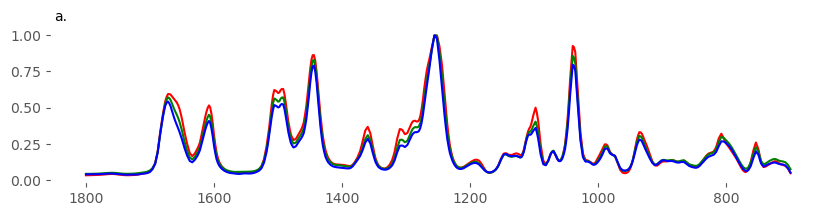

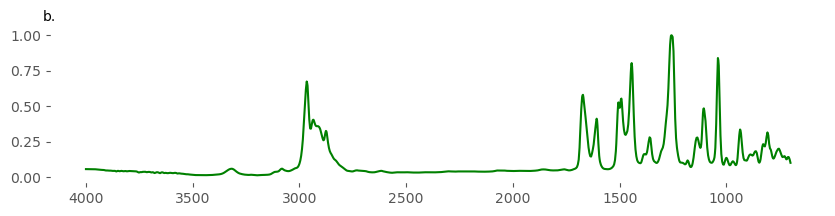

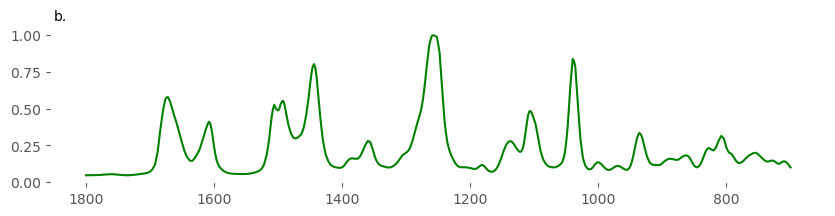

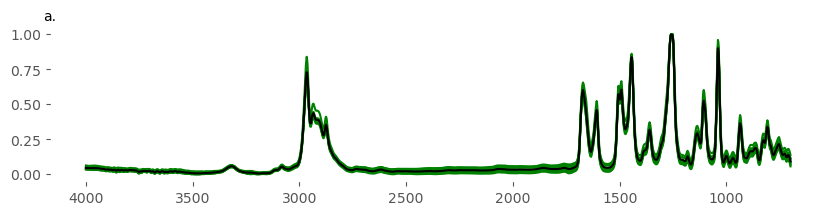

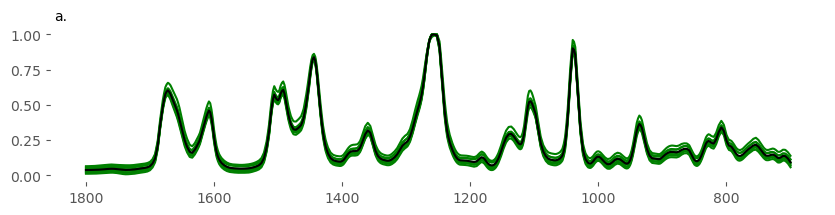

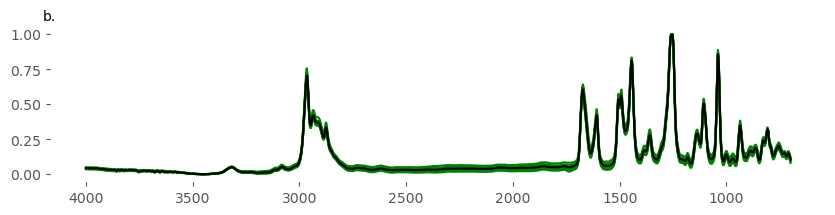

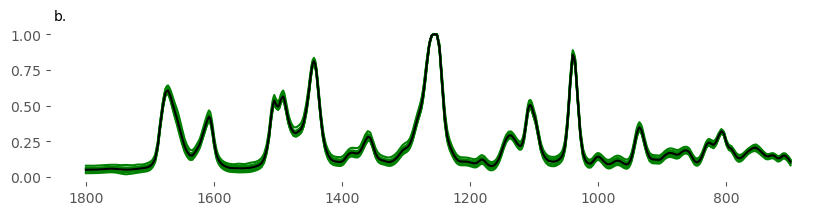

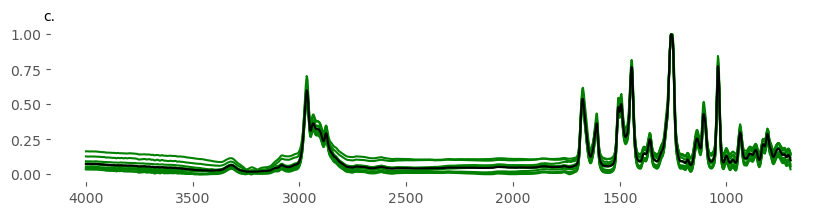

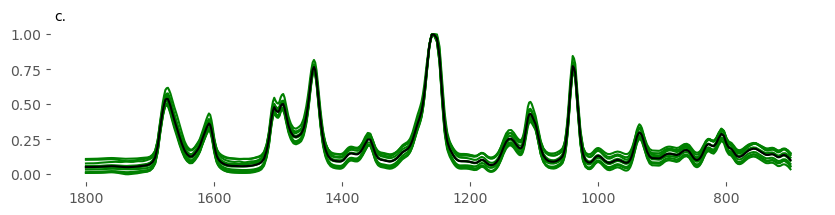

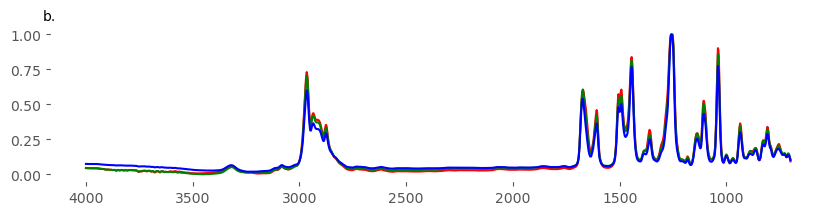

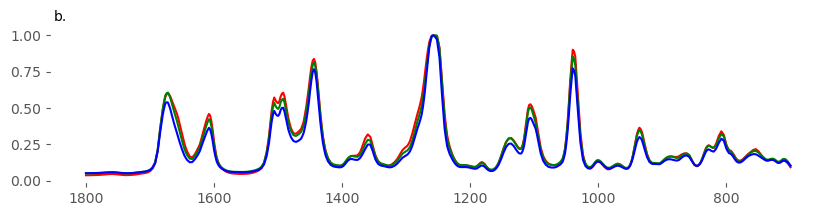

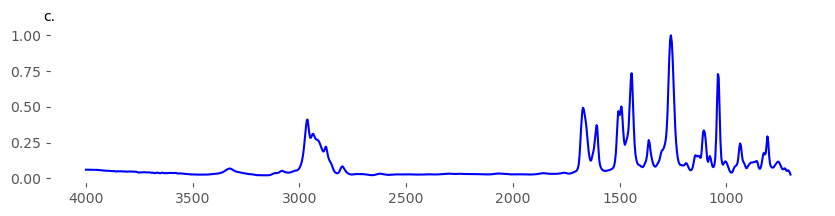

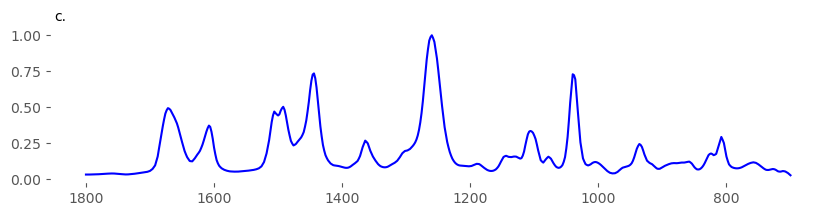

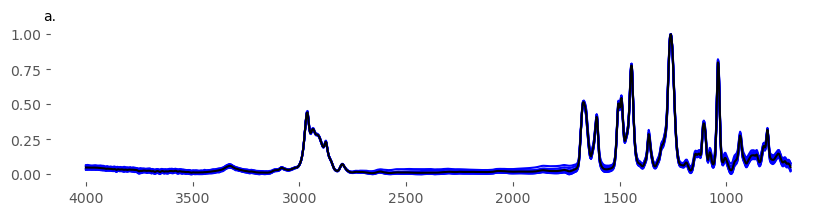

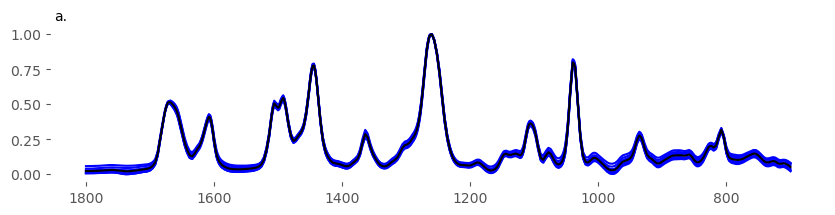

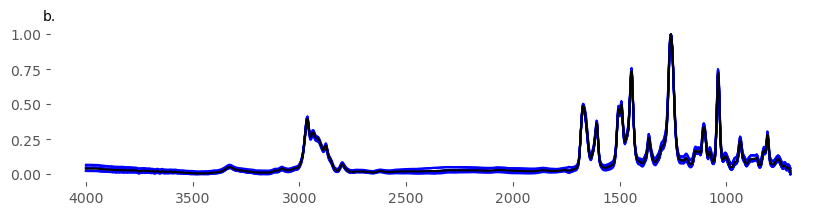

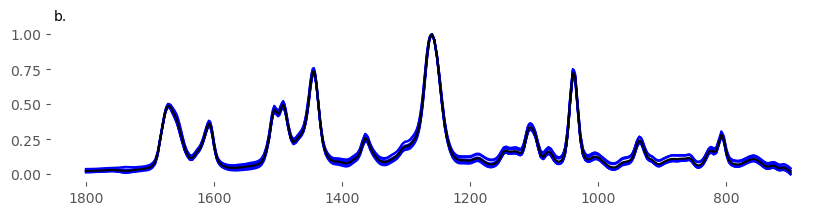

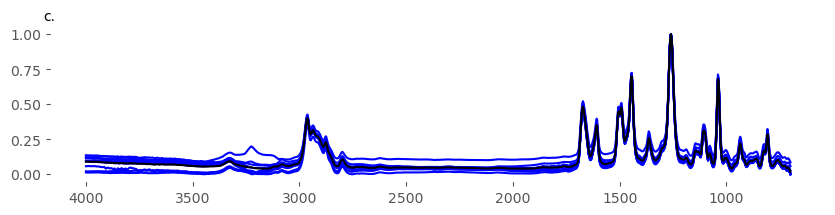

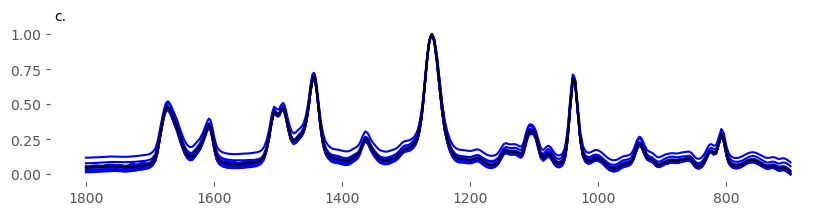

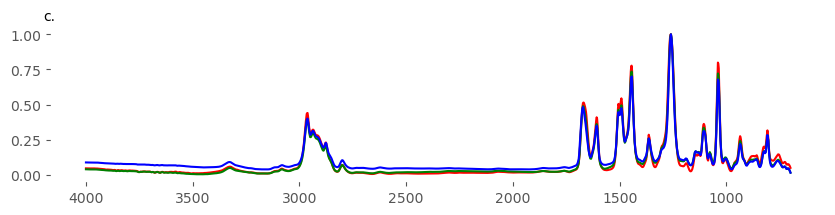

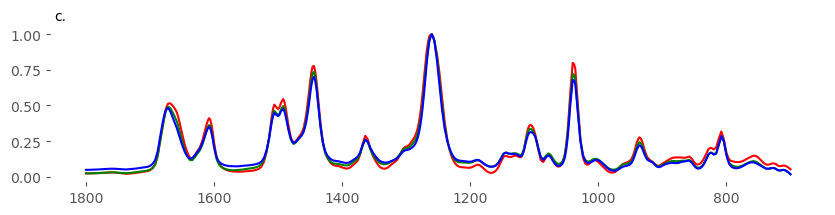

In [13]:
#Plot compounds by week
label_primary = pd.read_pickle("label_primary.pkl")    #Load label data
labels_primary = sorted(np.unique(label_primary), key=str.casefold)  #Create sorted list of unique compounds

label_train = pd.read_pickle("label_train.pkl")    #Load label data
label_val1 = pd.read_pickle("label_val1.pkl")
label_val2 = pd.read_pickle("label_val2.pkl")

colors = ['r', 'g', 'b']                               #Create list of colors
target_names = ['methylone','N-ethylpentylone','pentylone'] #Create list of full names for plotting
text_list = ['a.', 'b.', 'c.']

for color, label, text, name in zip(colors, labels_primary, text_list, target_names):
    data_train = pd.read_pickle("data_train.pkl")      #Load train (week 1) data
    data_val1 = pd.read_pickle("data_val1.pkl")      #Load week 2 data
    data_val2 = pd.read_pickle("data_val2.pkl")      #Load week 3 data
    data_primary = pd.read_pickle("data_primary.pkl")      #Load primary data
    
    data_primary = data_primary[label_primary == label]
    data_train = data_train[label_train == label]
    data_val1 = data_val1[label_val1 == label]
    data_val2 = data_val2[label_val2 == label]
    
    #All average
    plt.figure(figsize=(10,2))                         #Set figure size
    plot_avg = data_primary.mean(axis = 0)
    plt.plot(plot_avg, color = color)
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(4200,1.1, text)
    plt.savefig(f'Normalized_APL_Spectra_{name}_Average.pdf', dpi = 600) #Save plot
    plt.show()
    
    plt.figure(figsize=(10,2))                         #Set figure size
    plt.plot(plot_avg[0:551], color = color)
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(1850,1.1, text)
    plt.savefig(f'Normalized_APL_Spectra_{name}_Average_zoomed.pdf', dpi = 600) #Save plot
    plt.show()
    
    #week 1
    plt.figure(figsize=(10,2))                         #Set figure size
    for j in range(0, data_train.shape[0]):           #Plot each spectrum
        plt.plot(data_train.iloc[j,:], color = color)  #Plot each spectrum, by color
    plot_avg1 = data_train.mean(axis = 0)
    plt.plot(plot_avg1, color = "black")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(4200,1.1, 'a.')
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_1.pdf', dpi = 600) #Save plot
    plt.show()
    
    plt.figure(figsize=(10,2))                         #Set figure size
    for j in range(0, data_train.shape[0]):           #Plot each spectrum
        plt.plot(data_train.iloc[j,0:551], color = color)  #Plot each spectrum, by color
    plt.plot(plot_avg1[0:551], color = "black")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(1850,1.1, 'a.')
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_1_zoomed.pdf', dpi = 600) #Save plot
    plt.show()
    
    #Week 2
    plt.figure(figsize=(10,2))                         #Set figure size
    for j in range(0, data_val1.shape[0]):           #Plot each spectrum
        plt.plot(data_val1.iloc[j,:], color = color)  #Plot each spectrum, by color
    plot_avg2 = data_val1.mean(axis = 0)
    plt.plot(plot_avg2, color = "black")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(4200,1.1, 'b.')
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_2.pdf', dpi = 600) #Save plot
    plt.show()
    
    plt.figure(figsize=(10,2))                         #Set figure size
    for j in range(0, data_val1.shape[0]):           #Plot each spectrum
        plt.plot(data_val1.iloc[j,0:551], color = color)  #Plot each spectrum, by color
    plt.plot(plot_avg2[0:551], color = "black")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(1850,1.1, 'b.')
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_2_zoomed.pdf', dpi = 600) #Save plot
    plt.show()
    
    #week 3
    plt.figure(figsize=(10,2))                         #Set figure size
    for j in range(0, data_val2.shape[0]):           #Plot each spectrum
        plt.plot(data_val2.iloc[j,:], color = color)  #Plot each spectrum, by color
    plot_avg3 = data_val2.mean(axis = 0)
    plt.plot(plot_avg3, color = "black")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(4200,1.1, 'c.')
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_3.pdf', dpi = 600) #Save plot
    plt.show()
    
    plt.figure(figsize=(10,2))                         #Set figure size
    for j in range(0, data_val2.shape[0]):           #Plot each spectrum
        plt.plot(data_val2.iloc[j,0:551], color = color)  #Plot each spectrum, by color
    plt.plot(plot_avg3[0:551], color = "black")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(1850,1.1, 'c.')
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_3_zoomed.pdf', dpi = 600) #Save plot
    plt.show()
    
    plt.figure(figsize=(10,2))                         #Set figure size
    plt.plot(plot_avg1, color = "red")
    plt.plot(plot_avg2, color = "green")
    plt.plot(plot_avg3, color = "blue")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(4200,1.1, text)
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_1-3.pdf', dpi = 600) #Save plot
    plt.show()
    
    plt.figure(figsize=(10,2))                         #Set figure size
    plt.plot(plot_avg1[0:551], color = "red")
    plt.plot(plot_avg2[0:551], color = "green")
    plt.plot(plot_avg3[0:551], color = "blue")
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.text(1850,1.1, text)
    plt.savefig(f'Normalized_APL_Spectra_{name}_week_1-3_zoomed.pdf', dpi = 600) #Save plot
    plt.show()


## Plot DFS Data

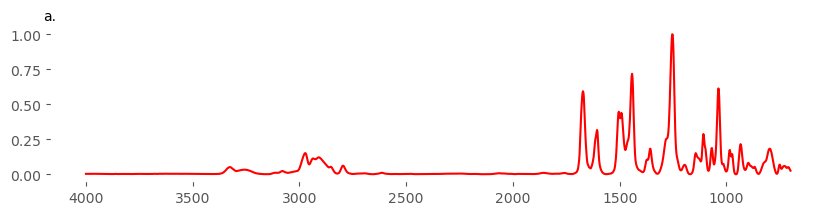

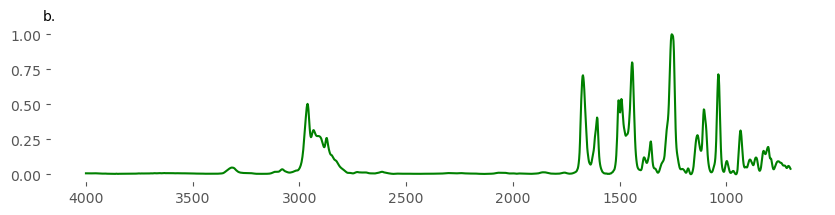

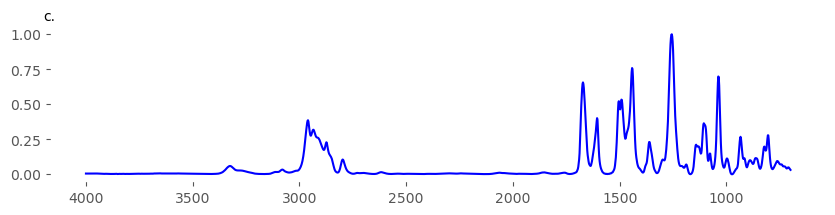

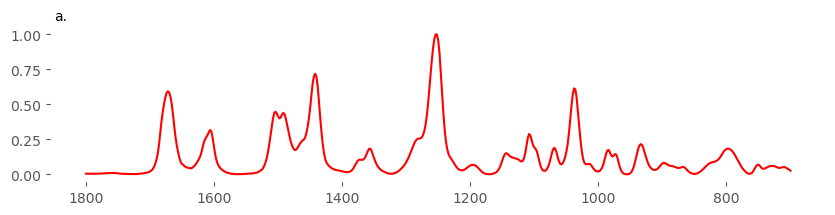

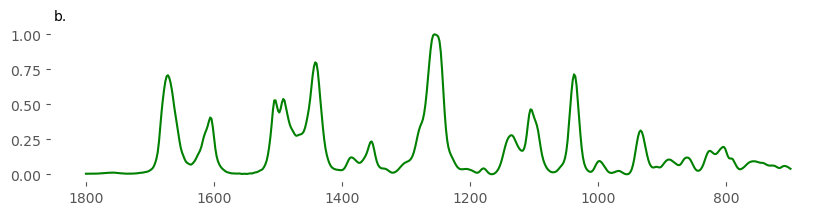

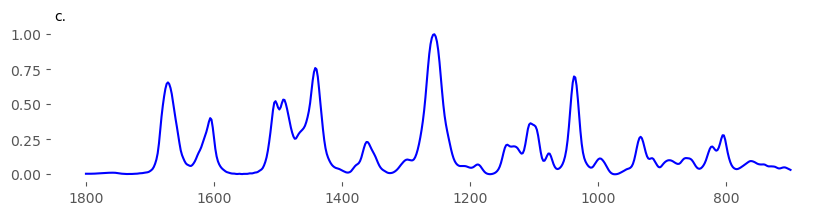

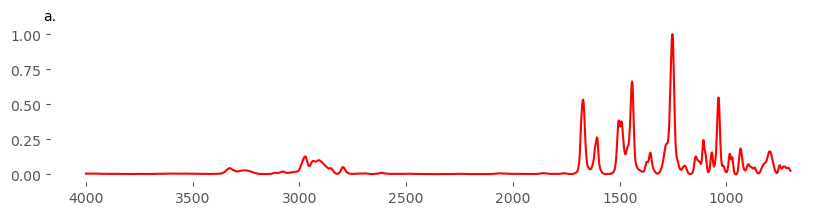

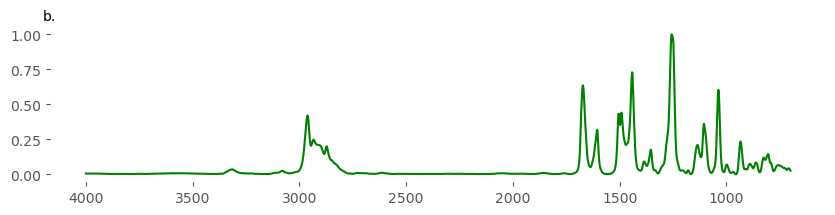

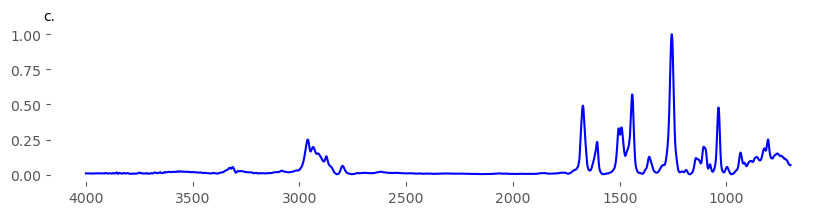

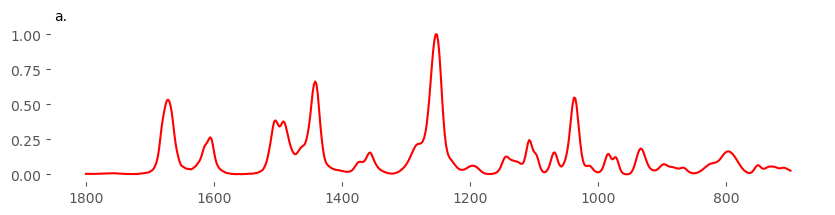

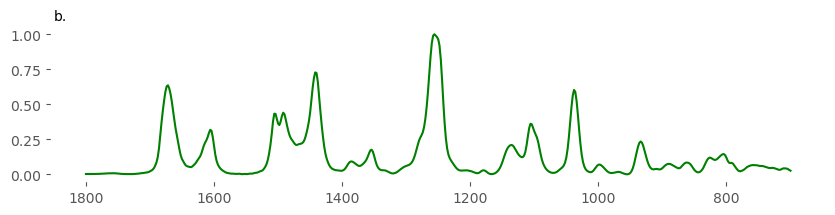

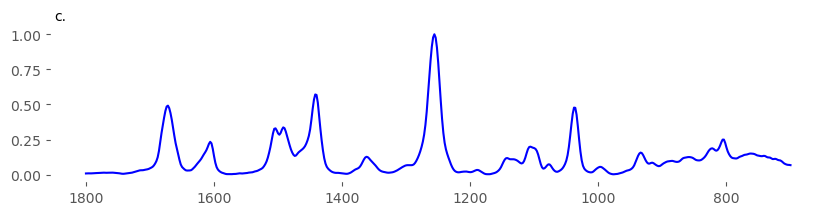

In [29]:
#Methanol samples
data_dfs_meoh = pd.read_pickle("data_dfs_meoh.pkl")                   #Load DFS Data
label_dfs_meoh = pd.read_pickle("label_dfs_meoh.pkl")                 #Load DFS Labels
labels_dfs_meoh = sorted(np.unique(label_dfs_meoh), key=str.casefold) #Create sorted list of unique labels

colors = ['r', 'g', 'b']                           #Create array of colors    
target_names = ['methylone','N-ethylpentylone','pentylone']  #Create array of Target names
text_list = ['a.','b.','c.']

for k in range(0, len(labels_dfs_meoh)):                        #for each unique label
    data_temp_1 = data_dfs_meoh[label_dfs_meoh == labels_dfs_meoh[k]]  #Temp data of only that compounds
    plt.figure(figsize=(10,2))                         #Set figure size
    plot_avg = data_temp_1.mean(axis = 0)
    plt.plot(plot_avg, color = colors[k])
    plt.text(4200, 1.1, text_list[k])
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.savefig(f'Normalized_avg_DFS_Spectra_{labels_dfs_base[k]}_meoh.pdf', dpi = 600) #Save plot
    plt.show()                                         #Show plot

for k in range(0, len(labels_dfs_meoh)):                        #for each unique label
    data_temp_1 = data_dfs_meoh[label_dfs_meoh == labels_dfs_meoh[k]] #Set temp data of only that compuds
    plt.figure(figsize=(10,2))                         #Set figure size
    plot_avg = data_temp_1.mean(axis = 0)
    plt.plot(plot_avg[0:551], color = colors[k])
    plt.text(1850, 1.1, text_list[k])
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    
    plt.savefig(f'Normalized_avg_DFS_Spectra_zoomed_{labels_dfs_base[k]}_meoh.pdf', dpi = 600)  #Save plot
    plt.show()                                         #Show plot 

#base extracted samples
data_dfs_base = pd.read_pickle("data_dfs_base.pkl")                   #Load DFS Data
label_dfs_base = pd.read_pickle("label_dfs_base.pkl")                 #Load DFS Labels
labels_dfs_base = sorted(np.unique(label_dfs_base), key=str.casefold) #Create sorted list of unique labels

for k in range(0, len(labels_dfs_base)):                        #for each unique label
    data_temp_1 = data_dfs_base[label_dfs_base == labels_dfs_base[k]]  #Temp data of only that compounds
    plt.figure(figsize=(10,2))                         #Set figure size
    plot_avg = data_temp_1.mean(axis = 0)
    plt.plot(plot_avg, color = colors[k])
    plt.text(4200, 1.1, text_list[k])
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.savefig(f'Normalized_avg_DFS_Spectra_{labels_dfs_base[k]}_base.pdf', dpi = 600) #Save plot
    plt.show()                                         #Show plot

for k in range(0, len(labels_dfs_base)):                        #for each unique label
    data_temp_1 = data_dfs_base[label_dfs_base == labels_dfs_base[k]] #Set temp data of only that compuds
    plt.figure(figsize=(10,2))                         #Set figure size
    plot_avg = data_temp_1.mean(axis = 0)
    plt.plot(plot_avg[0:551], color = colors[k])
    plt.text(1850, 1.1, text_list[k])
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    
    plt.savefig(f'Normalized_avg_DFS_Spectra_zoomed_{labels_dfs_base[k]}_base.pdf', dpi = 600)  #Save plot
    plt.show()                                         #Show plot 


## Plot APL Test (Methanol Samples)

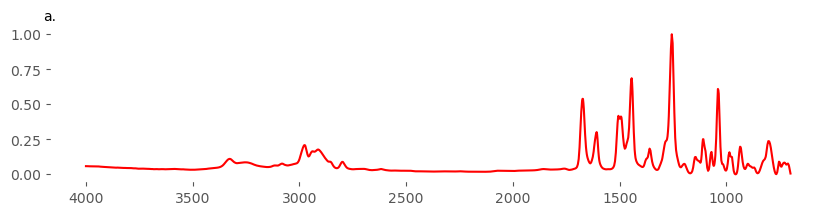

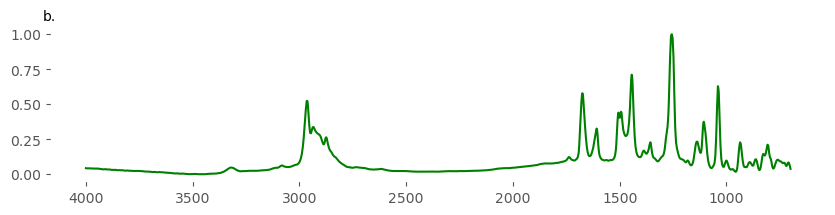

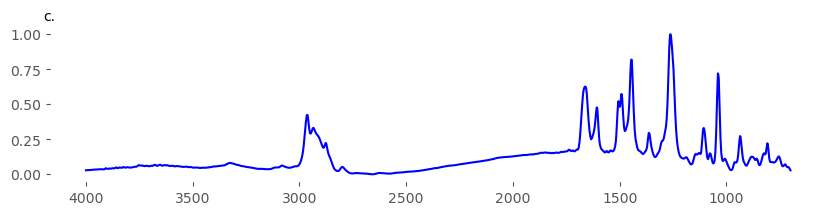

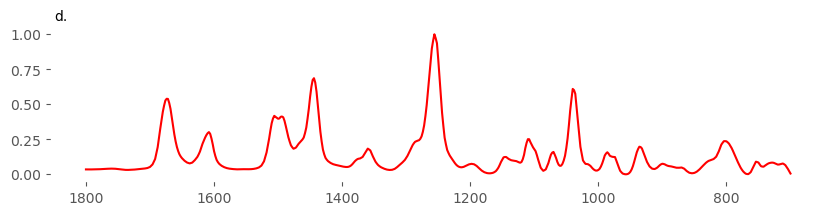

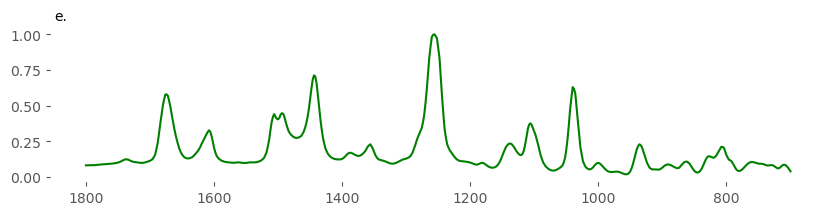

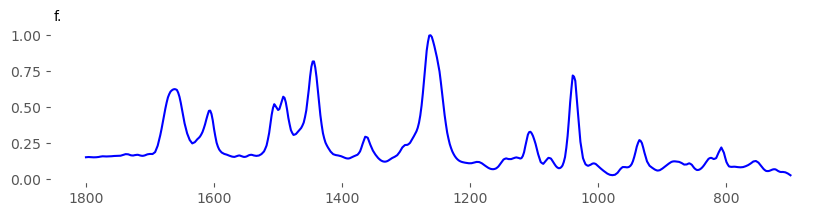

In [30]:
data_test_meoh = pd.read_pickle("data_test_meoh.pkl")              #Load test data (when library samples are imported)
label_test_meoh = pd.read_pickle("label_test_meoh.pkl")            #Load label data
labels_test_meoh = sorted(np.unique(label_test_meoh), key=str.casefold)  #Create sorted list of unique labels

colors = ['r', 'g', 'b']    
target_names = ['methylone','N-ethylpentylone', 'pentylone']
text_list = ['a.','b.','c.']
text_list_fp = ['d.','e.','f.']

for k in range(0, len(labels_test_meoh)):
    data_temp_1 = data_test_meoh[label_test_meoh == labels_test_meoh[k]]
    plt.figure(figsize=(10,2))
    for j in range(0, data_temp_1.shape[0]):
        plt.plot(data_temp_1.iloc[j,:], label = target_names[k], color = colors[k])
    plt.text(4200, 1.1, text_list[k])
    plt.gca().invert_xaxis()
    plt.savefig(f'APL_library_{target_names[k]}.pdf', dpi = 600)
    plt.show()

for k in range(0, len(labels_test_meoh)):
    data_temp_1 = data_test_meoh[label_test_meoh == labels_test_meoh[k]]
    plt.figure(figsize=(10,2))
    for j in range(0, data_temp_1.shape[0]):
        plt.plot(data_temp_1.iloc[j,0:551], label = target_names[k], color = colors[k])
    plt.text(1850, 1.1, text_list_fp[k])
    plt.gca().invert_xaxis()
    plt.savefig(f'APL_library_zoomed_{target_names[k]}.pdf', dpi = 600)
    plt.show()


## Plot Others

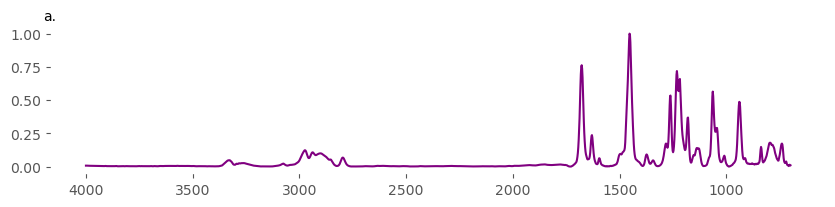

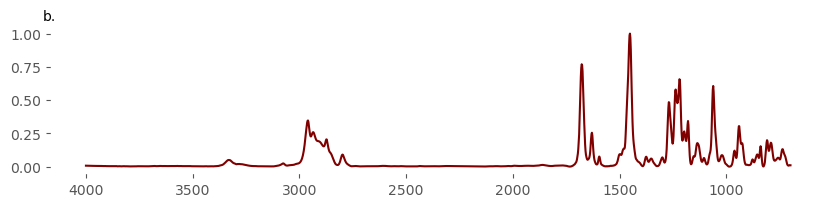

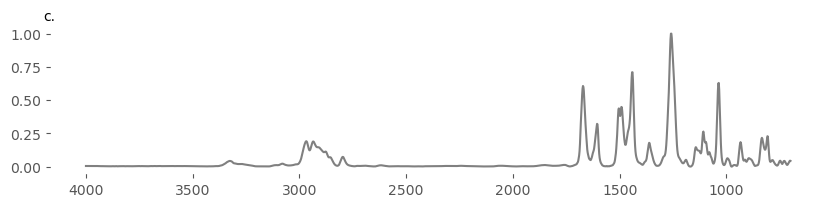

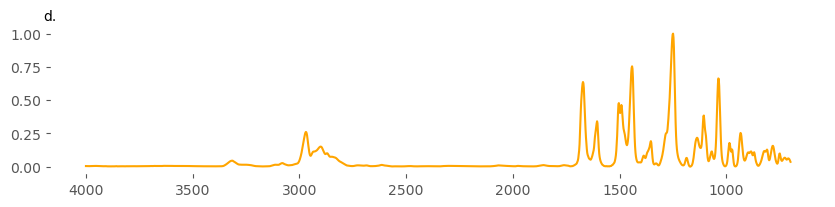

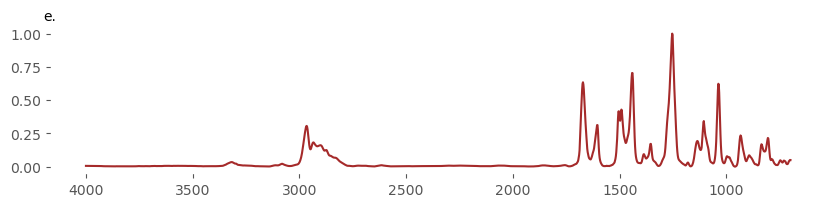

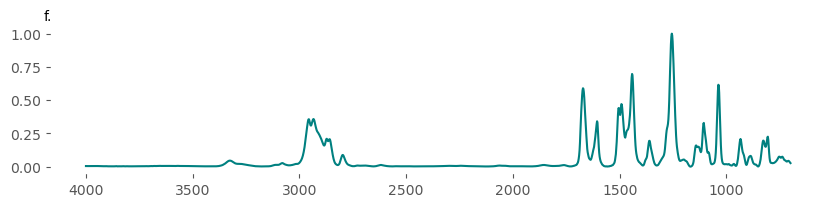

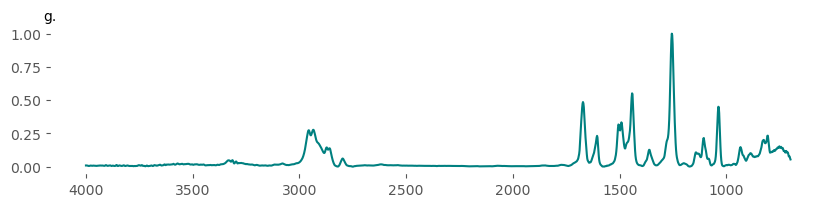

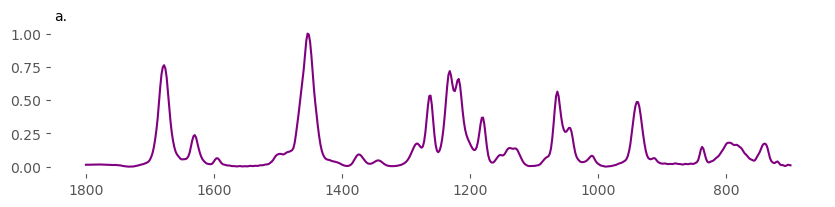

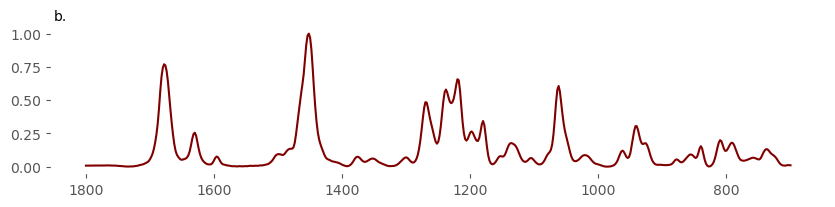

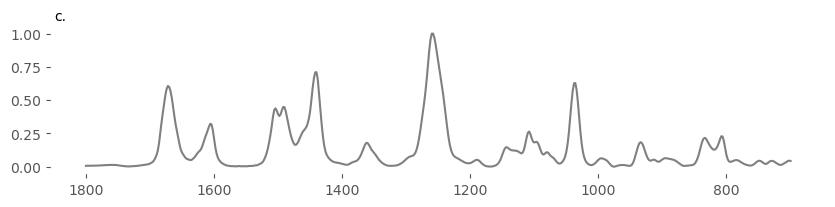

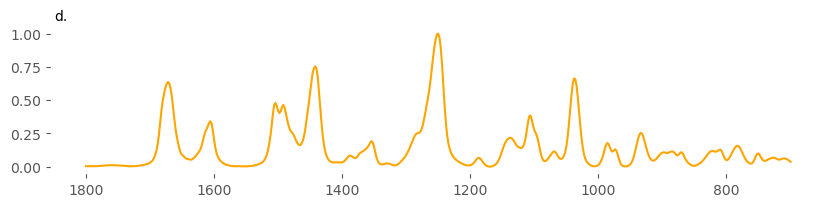

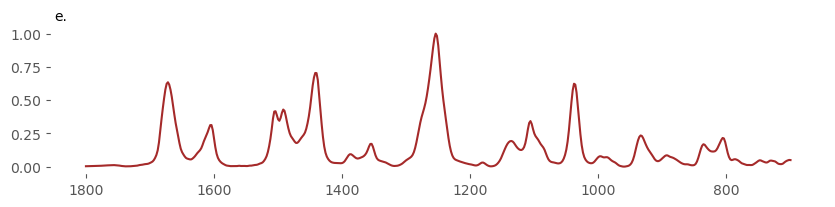

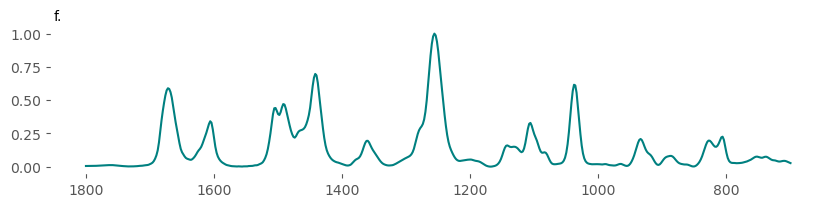

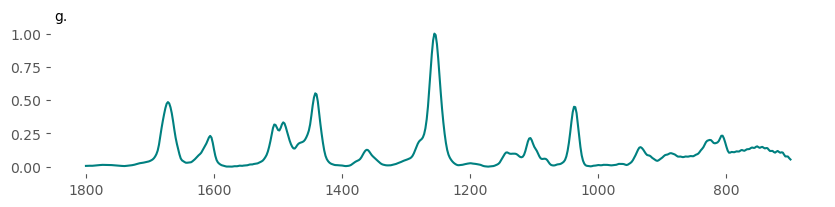

In [34]:
data_other = pd.read_pickle("data_other.pkl")                   #Load DFS Data
label_other = pd.read_pickle("label_other.pkl")                 #Load DFS Labels
labels_other = sorted(np.unique(label_other), key=str.casefold) #Create sorted list of unique labels

colors = ['purple', 'maroon', 'gray',  'orange', 'brown', 'teal', 'teal']                           #Create array of colors    
target_names = ['2,3-methylone', '2,3-pentylone', 'butylone', 'ethylone', 'eutylone', 'N-methylhexylone - MeOH', 'N-methylhexylone - base']  #Create array of Target names
text_list = ['a.','b.','c.', 'd.', 'e.', 'f.', 'g.']

for k in range(0, len(labels_other)):                        #for each unique label
    data_temp_1 = data_other[label_other == labels_other[k]]  #Temp data of only that compounds
    plt.figure(figsize=(10,1.9))                         #Set figure size
    plot_avg = data_temp_1.mean(axis = 0)
    plt.plot(plot_avg, color = colors[k])
    plt.text(4200, 1.1, text_list[k])
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.savefig(f'Normalized_avg_DFS_Spectra_{labels_other[k]}.pdf', dpi = 600) #Save plot
    plt.show()                                         #Show plot

for k in range(0, len(labels_other)):                        #for each unique label
    data_temp_1 = data_other[label_other == labels_other[k]] #Set temp data of only that compuds
    plt.figure(figsize=(10,1.9))                         #Set figure size
    plot_avg = data_temp_1.mean(axis = 0)
    plt.plot(plot_avg[0:551], color = colors[k])
    plt.text(1850, 1.1, text_list[k])
    plt.gca().invert_xaxis()                           #Invert axis so X-axis starts at the higher wavenumber
    plt.savefig(f'Normalized_avg_DFS_Spectra_zoomed_{labels_other[k]}.pdf', dpi = 600)  #Save plot
    plt.show()                                         #Show plot 


## PCA - All Primary

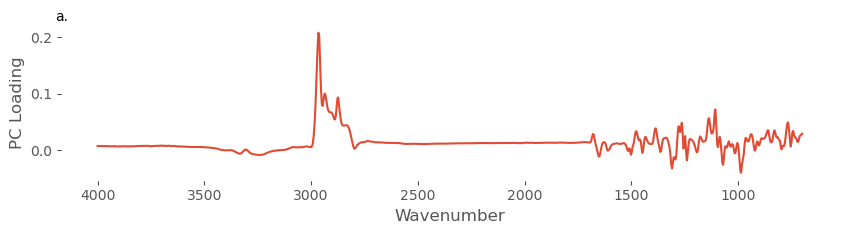

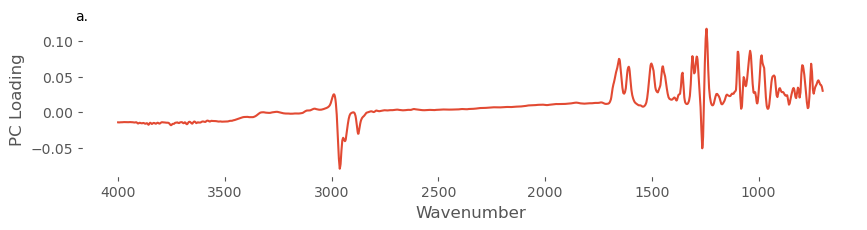

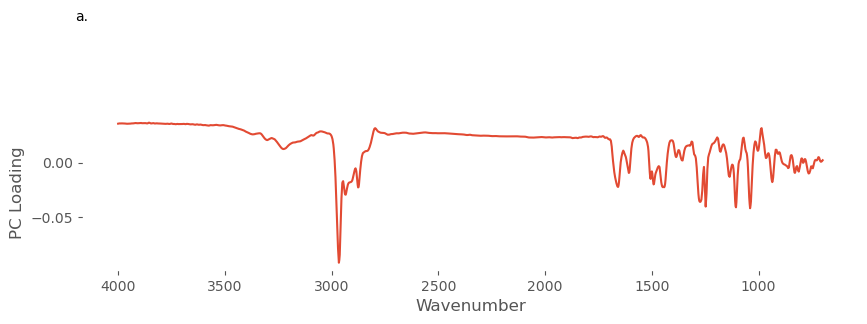

88.3


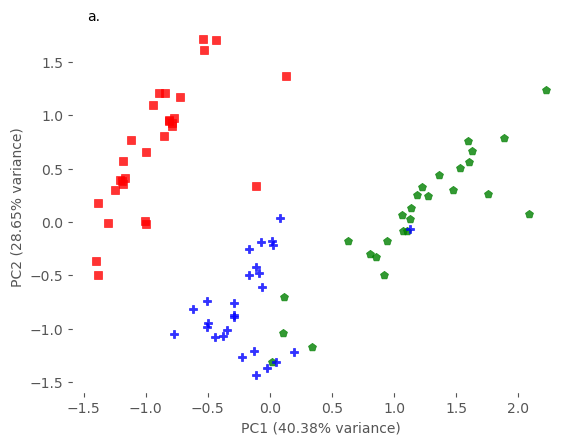

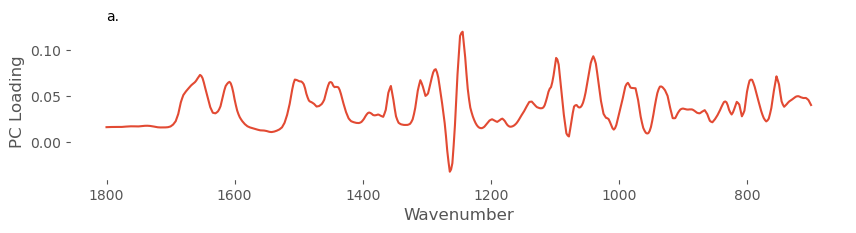

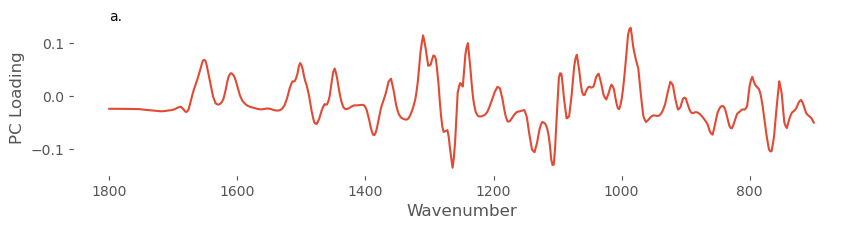

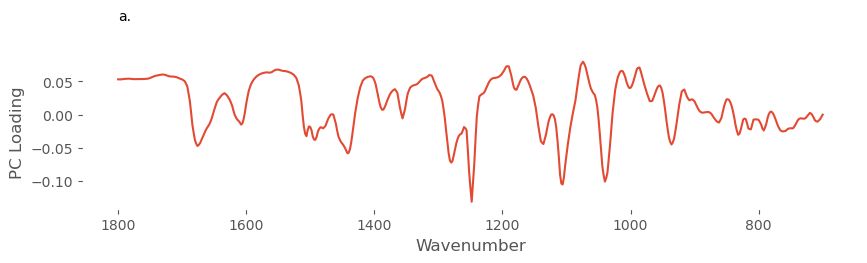

88.6


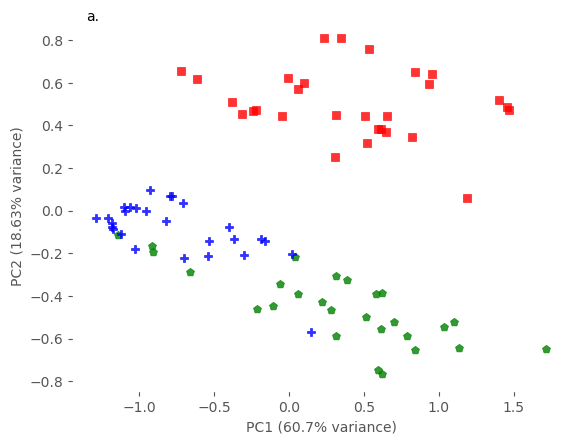

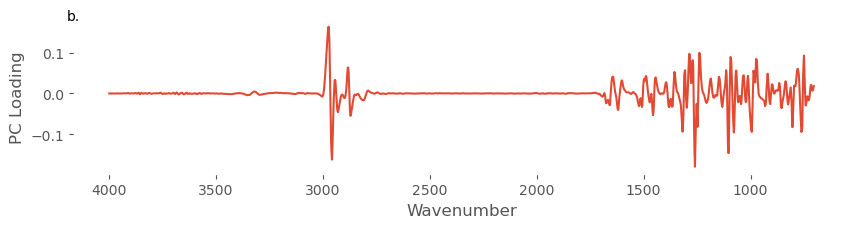

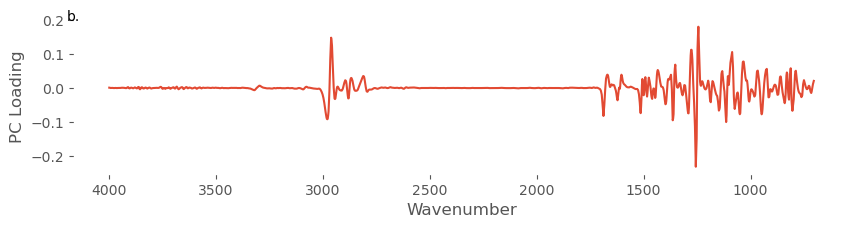

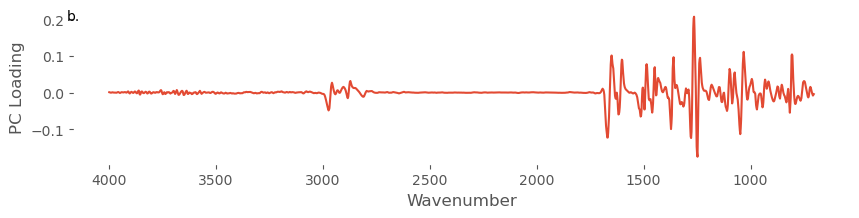

95.54


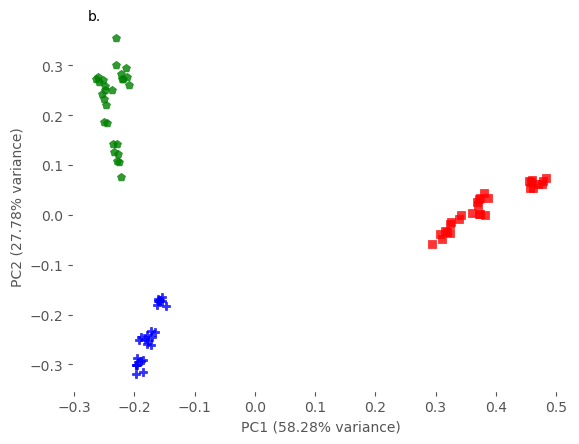

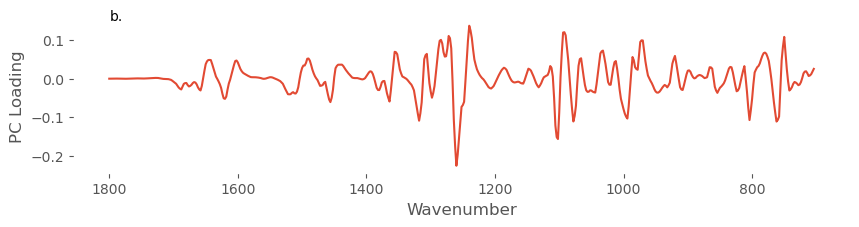

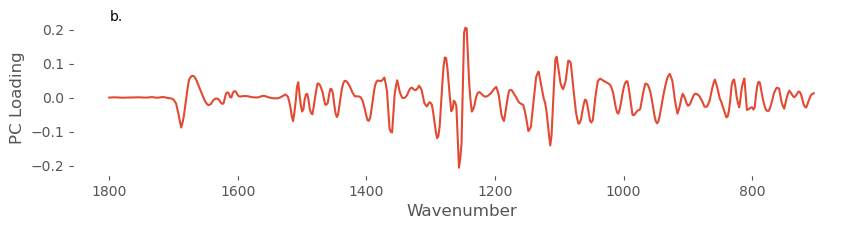

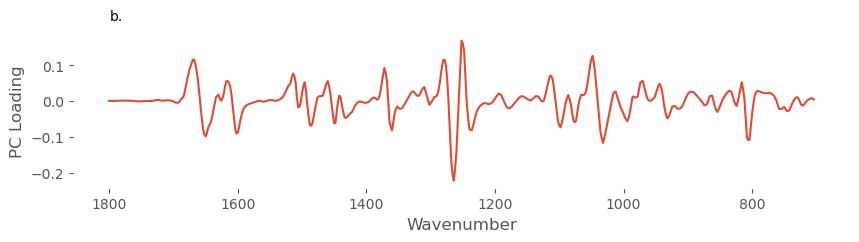

94.91


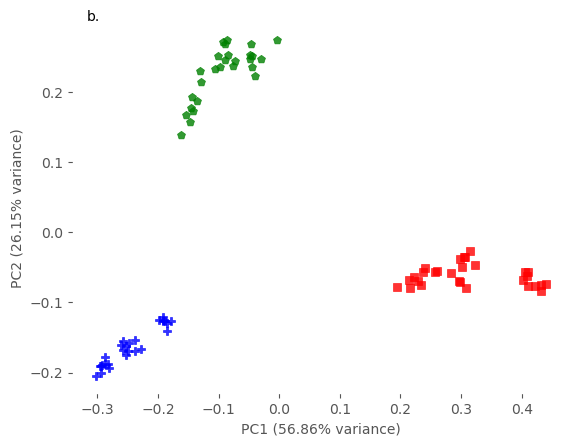

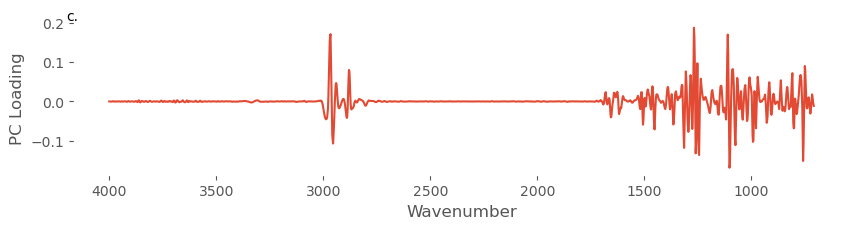

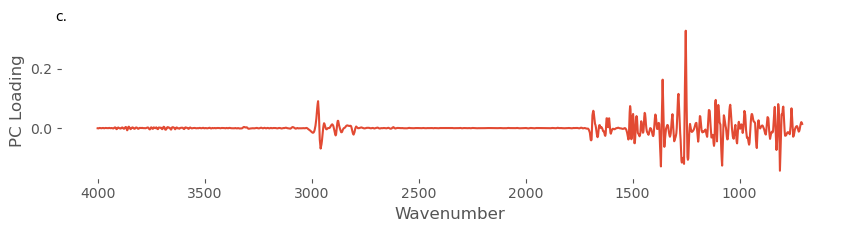

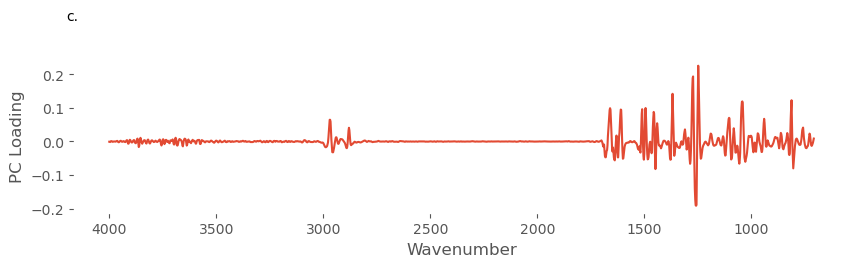

94.83


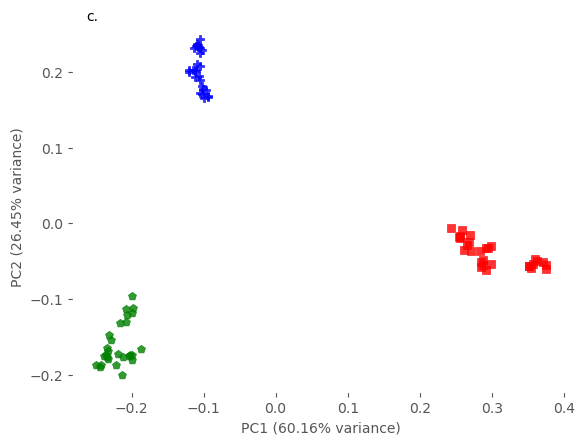

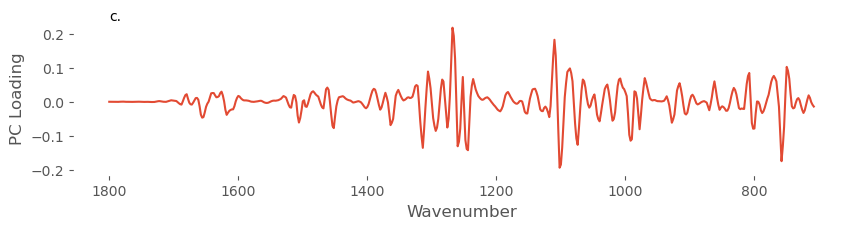

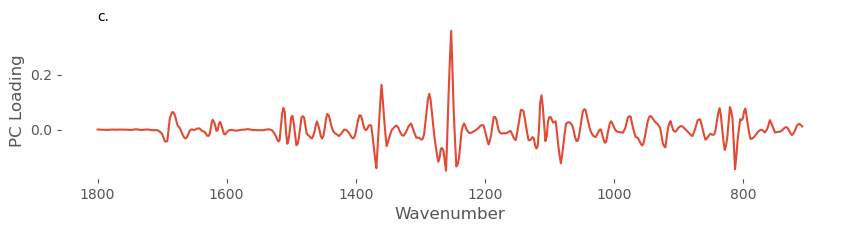

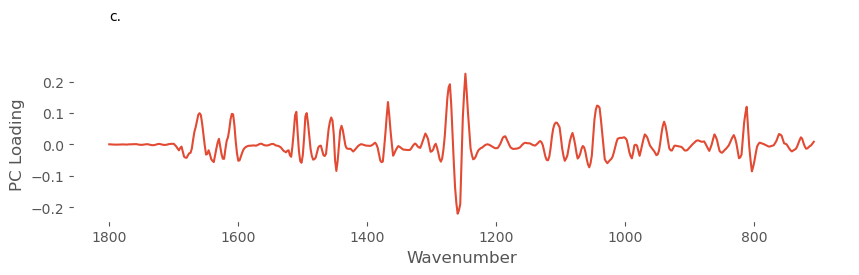

95.00999999999999


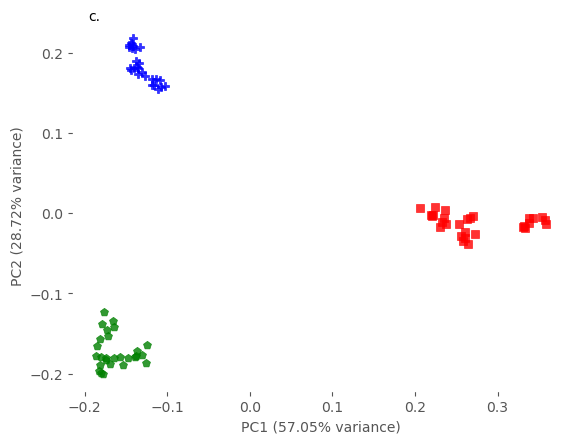

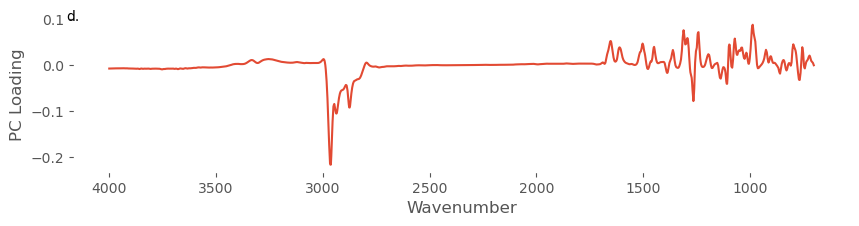

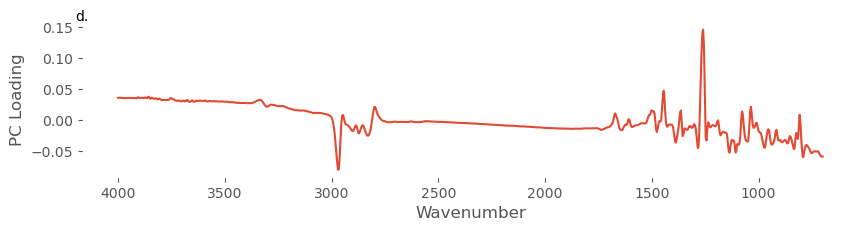

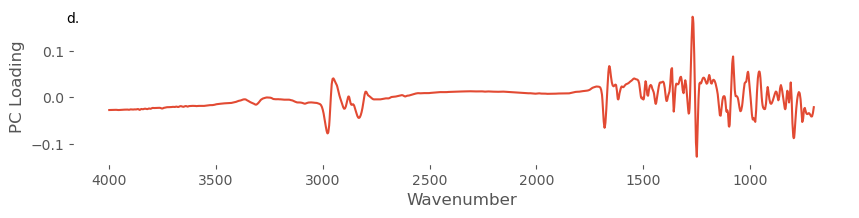

87.97


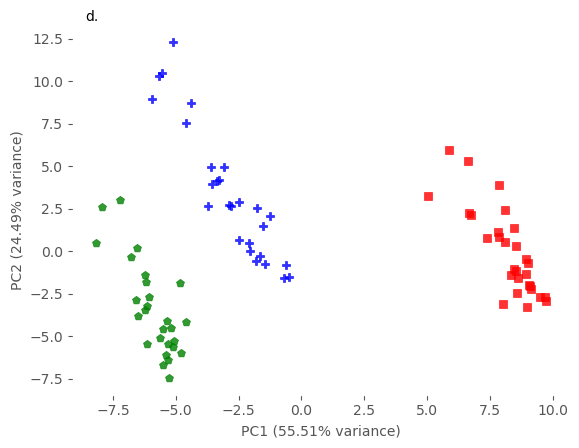

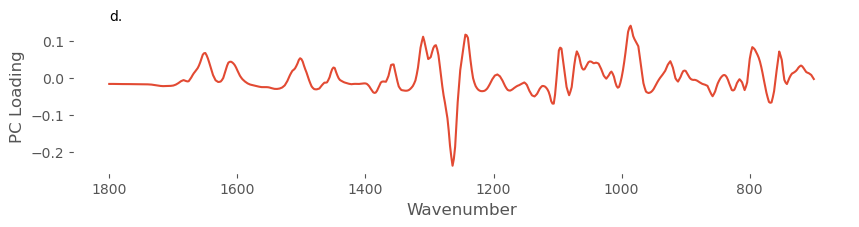

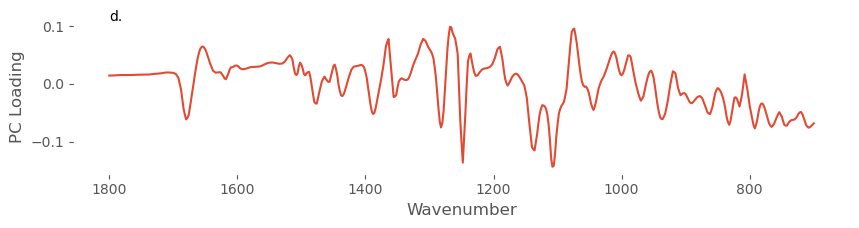

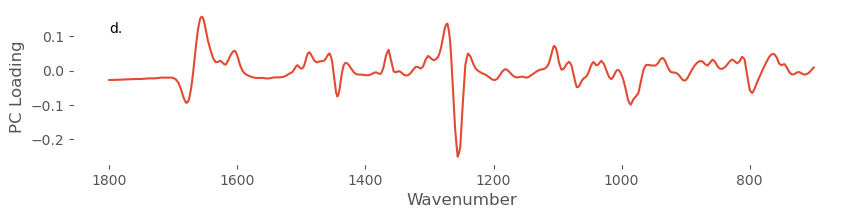

89.10999999999999


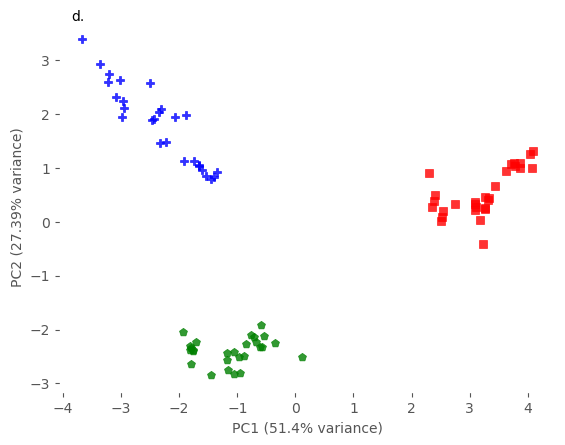

In [12]:
label_primary = pd.read_pickle("label_primary.pkl")
labels_primary = sorted(np.unique(label_primary), key=str.casefold)

preprocessing = ["original", "first", "second", "snv"]

colors = ['r', 'g', 'b']
target_names = ['methylone','N-ethylpentylone','pentylone']
marker_val = ("s", "p", "P")
text = ('a.', 'b.', 'c.','d.')

for process in range(0,4):
    data_train = pd.read_pickle("data_primary.pkl") 
    mahal_train = pd.DataFrame(columns = ('methylone', 'N-ethylpentylone', 'pentylone'), index = data_train.index)

    data_train_fp = fingerprint(data_train)
    data_list = list((data_train, data_train_fp))
    
    for dat in range(0,2):
        if process == 1:
            data_list[dat] = baseline(data_list[dat], type = "first_deriv")
        if process == 2:
            data_list[dat] = baseline(data_list[dat], type = "second_deriv")
        if process == 3:
            data_list[dat] = scatter(data_list[dat], type = "snv")
    
    data_train, data_train_fp = data_list
    
    #PCA
    pca = PCA(n_components=5)    #set to perform PCA 
    np.random.seed(7)                 #set random seed
    pca.fit(data_train)               #Perform PCA on training set

    df_pca = pd.DataFrame(pca.components_, columns  = data_train.columns)                #Save to dataframe
    df_pca.to_excel(f'PCA_Loadings_{preprocessing[process]}.xlsx')
    plt.figure(figsize=(10,2))  
    plt.plot(df_pca.iloc[0,:])                    #Plot first PC loading 
    plt.gca().invert_xaxis()
    plt.ylabel(f'PC Loading')
    plt.xlabel(f'Wavenumber')
    text_y = max(df_pca.iloc[0, :]) * 1.1
    plt.text(4200, text_y, text[process])
    # plt.savefig(f'PCA_loadings_PC1_{preprocessing[process]}.pdf', dpi = 600)
    plt.show()
   
    plt.figure(figsize=(10,2))  
    plt.plot(df_pca.iloc[1,:])                    #Plot first PC loading 
    plt.gca().invert_xaxis()
    plt.ylabel(f'PC Loading')
    plt.xlabel(f'Wavenumber')
    text_y = max(df_pca.iloc[1, :]) * 1.1
    plt.text(4200, text_y, text[process])
    # plt.savefig(f'PCA_loadings_PC2_{preprocessing[process]}.pdf', dpi = 600)
    plt.show()

    plt.figure(figsize=(10,2))  
    plt.plot(df_pca.iloc[2,:])                    #Plot first PC loading 
    plt.gca().invert_xaxis()
    plt.ylabel(f'PC Loading')
    plt.xlabel(f'Wavenumber')
    text_y = max(df_pca.iloc[1, :]) * 1.1
    plt.text(4200, text_y, text[process])
    plt.savefig(f'PCA_loadings_PC3_{preprocessing[process]}.pdf', dpi = 600)
    plt.show()
    
    #PCA plot
    data_plot = pca.transform(data_train)
    
    fig = plt.figure()
    ax = plt.axes()
        
    for color, z, target_name, marker in zip(colors, labels_primary, target_names, marker_val):
        ax.scatter(data_plot[label_primary == z, 0], data_plot[label_primary == z, 1], alpha=.8, color=color,
                    label=target_name, marker=marker)  # plot training set
   
    pc1 = np.round(pca.explained_variance_ratio_[0] * 100, 2)  # calculate lda variances
    pc2 = np.round(pca.explained_variance_ratio_[1] * 100, 2)
    pc3 = np.round(pca.explained_variance_ratio_[2] * 100, 2)
    print(pc1+pc2+pc3)
    
    # plt.legend(bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=3, shadow=False, scatterpoints=1)  # plot legend
    plt.xlabel(f'PC1 ({pc1}% variance)', fontsize = 10)
    plt.ylabel(f'PC2 ({pc2}% variance)', fontsize = 10)
    text_x = min(data_plot[:,0])*1.05
    text_y = max(data_plot[:,1])*1.1
    plt.text(text_x, text_y, text[process])
    # plt.savefig(f'APL_PCA_{preprocessing[process]}_primary.pdf', dpi = 600)
    plt.show()

    #Mahalanobis distance
    for sample in range(0,len(data_train.index)):           
        for cmpd in range(0,3):
            test = data_train.iloc[sample]
            train_lbl = label_primary[label_primary.index != label_primary.index[sample]]
            train = data_train.iloc[data_train.index != data_train.index[sample]]
            pca.fit(train)
            pca_mahal_train = pca.transform(train)
            mahal_test = pca.transform(pd.DataFrame(test).transpose())
            mahal_train.iloc[sample,cmpd] = mahalanobis(mahal_test[:,0:3], pca_mahal_train[train_lbl == labels_primary[cmpd],0:3]).astype(float)
    
    mahal_train = mahal_train.astype(float)   
    mahal_train.to_excel(f'Mahalanobis_primary_{preprocessing[process]}3.xlsx')

    np.random.seed(7)                 #set random seed
    pca.fit(data_train_fp)               #Perform PCA on training set - fingerprint only
    
    df_pca = pd.DataFrame(pca.components_, columns  = data_train_fp.columns)                #Save to dataframe
    df_pca.to_excel(f'PCA_Loadings_{preprocessing[process]}_fp.xlsx')
    plt.figure(figsize=(10,2))  
    plt.plot(df_pca.iloc[0,:])                    #Plot first PC loading 
    plt.gca().invert_xaxis()
    plt.ylabel(f'PC Loading')
    plt.xlabel(f'Wavenumber')
    text_y = max(df_pca.iloc[0, :]) * 1.1
    plt.text(1800, text_y, text[process])    
    # plt.savefig(f'PCA_loadings_PC1_{preprocessing[process]}_fp.pdf', dpi = 600)
    plt.show()
   
    plt.figure(figsize=(10,2))  
    plt.plot(df_pca.iloc[1,:])                    #Plot first PC loading 
    plt.gca().invert_xaxis()
    plt.ylabel(f'PC Loading')
    plt.xlabel(f'Wavenumber')
    text_y = max(df_pca.iloc[1, :]) * 1.1
    plt.text(1800, text_y, text[process])    
    # plt.savefig(f'PCA_loadings_PC2_{preprocessing[process]}_fp.pdf', dpi = 600)
    plt.show()

    plt.figure(figsize=(10,2))  
    plt.plot(df_pca.iloc[2,:])                    #Plot first PC loading 
    plt.gca().invert_xaxis()
    plt.ylabel(f'PC Loading')
    plt.xlabel(f'Wavenumber')
    text_y = max(df_pca.iloc[1, :]) * 1.1
    plt.text(1800, text_y, text[process])    
    plt.savefig(f'PCA_loadings_PC3_{preprocessing[process]}_fp.pdf', dpi = 600)
    plt.show()

    #PCA plot fingerprint
    data_plot = pca.transform(data_train_fp)
    
    fig = plt.figure()
    ax = plt.axes()
    
    for color, z, target_name,  marker in zip(colors, labels_primary, target_names, marker_val):
        ax.scatter(data_plot[label_primary == z, 0], data_plot[label_primary == z, 1], alpha=.8, color=color,
                    label=target_name, marker = marker)  # plot training set
            
    pc1 = np.round(pca.explained_variance_ratio_[0] * 100, 2)  # calculate lda variances
    pc2 = np.round(pca.explained_variance_ratio_[1] * 100, 2)
    pc3 = np.round(pca.explained_variance_ratio_[2] * 100, 2)
    print(pc1+pc2+pc3)
    
    # plt.legend(bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=3, shadow=False, scatterpoints=1)  # plot legend
    plt.xlabel(f'PC1 ({pc1}% variance)', fontsize = 10)
    plt.ylabel(f'PC2 ({pc2}% variance)', fontsize = 10)
    text_x = min(data_plot[:,0])*1.05
    text_y = max(data_plot[:,1])*1.1
    plt.text(text_x, text_y, text[process])
    # plt.savefig(f'APL_PCA_{preprocessing[process]}_fp_primary.pdf', dpi = 600)
    plt.show()

    for sample in range(0,len(data_train_fp.index)):            
        for cmpd in range(0,3):
            test = data_train_fp.iloc[sample]
            train_lbl = label_primary[label_primary.index != label_primary.index[sample]]
            train = data_train_fp.iloc[data_train_fp.index != data_train_fp.index[sample]]
            pca.fit(train)
            pca_mahal_train = pca.transform(train)
            mahal_test = pca.transform(pd.DataFrame(test).transpose())
            mahal_train.iloc[sample,cmpd] = mahalanobis(mahal_test[:,0:3], pca_mahal_train[train_lbl == labels_primary[cmpd],0:3]).astype(float)

    mahal_train = mahal_train.astype(float)
    mahal_train.to_excel(f'Mahalanobis_primary_{preprocessing[process]}_fp3.xlsx')

## PCA - DFS

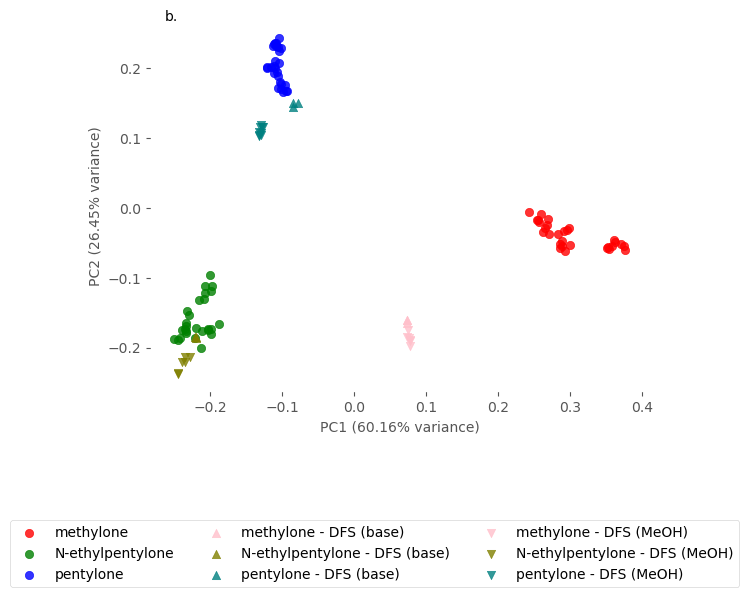

In [37]:
#Load label vectors and create arrays of sorted unique labels
label_dfs_base = pd.read_pickle("label_dfs_base.pkl")
labels_dfs_base = sorted(np.unique(label_dfs_base), key=str.casefold)

label_dfs_meoh = pd.read_pickle("label_dfs_meoh.pkl")
labels_dfs_meoh = sorted(np.unique(label_dfs_meoh), key=str.casefold)

label_primary = pd.read_pickle("label_primary.pkl")
labels_primary = sorted(np.unique(label_primary), key=str.casefold)

data_primary = pd.read_pickle("data_primary.pkl") #primary data set
data_dfs_meoh = pd.read_pickle("data_dfs_meoh.pkl") #DFS MeOH
data_dfs_base = pd.read_pickle("data_dfs_base.pkl") #DFS base

mahal_dfs_meoh = pd.DataFrame(columns = ('methylone', 'N-ethylpentylone', 'pentylone'), index = data_dfs_meoh.index)
mahal_dfs_base = pd.DataFrame(columns = ('methylone', 'N-ethylpentylone', 'pentylone'), index = data_dfs_base.index)
    
data_list = list((data_primary, data_dfs_meoh, data_dfs_base))
for dat in range(0,3):
    data_list[dat] = baseline(data_list[dat], type = "second_deriv")

data_primary, data_dfs_meoh, data_dfs_base = data_list

pca = PCA(n_components=5)    #set to perform PCA 
np.random.seed(7)                 #set random seed
pca.fit(data_primary)

pc1 = np.round(pca.explained_variance_ratio_[0] * 100, 2)  # calculate pca variances
pc2 = np.round(pca.explained_variance_ratio_[1] * 100, 2)

#PCA
data_plot = pca.transform(data_primary)
plot_dfs_meoh = pca.transform(data_dfs_meoh)
plot_dfs_base = pca.transform(data_dfs_base)

colors = ['r', 'g', 'b']
target_names = ['methylone','N-ethylpentylone','pentylone']
target_dfs_base = ['methylone - DFS (base)', 'N-ethylpentylone - DFS (base)', 'pentylone - DFS (base)'] 
target_dfs_meoh = ['methylone - DFS (MeOH)', 'N-ethylpentylone - DFS (MeOH)', 'pentylone - DFS (MeOH)'] 

colors_dfs = ['pink', 'olive', 'teal']

#Mahalanobis distance
for cmpd in range(0,3):
    mahal_dfs_meoh.iloc[:,cmpd] = mahalanobis(plot_dfs_meoh[:,0:3], data_plot[label_primary == labels_primary[cmpd],0:3])
    mahal_dfs_base.iloc[:,cmpd] = mahalanobis(plot_dfs_base[:,0:3], data_plot[label_primary == labels_primary[cmpd],0:3])

mahal_dfs_meoh.to_excel(f'Mahalanobis_dfs_meoh3.xlsx')
mahal_dfs_base.to_excel(f'Mahalanobis_dfs_base3.xlsx')

fig = plt.figure()
ax = plt.axes()

for color, z, target_name in zip(colors, labels_primary, target_names):
    ax.scatter(data_plot[label_primary == z, 0], data_plot[label_primary == z, 1], alpha=.8, color=color,
                label=target_name, marker = "o")  # plot training set
    
for color, z, target_name in zip(colors_dfs, labels_dfs_base, target_dfs_base):
    ax.scatter(plot_dfs_base[label_dfs_base ==z, 0], plot_dfs_base[label_dfs_base == z, 1], alpha=.8, color=color, marker = '^', label=target_name)

for color, z, target_name in zip(colors_dfs, labels_dfs_meoh, target_dfs_meoh):
    ax.scatter(plot_dfs_meoh[label_dfs_meoh ==z, 0], plot_dfs_meoh[label_dfs_meoh == z, 1], alpha=.8, color=color, marker = 'v', label=target_name)

plt.legend(bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=3, shadow=False, scatterpoints=1)  # plot legend
plt.xlabel(f'PC1 ({pc1}% variance)', fontsize = 10)
plt.ylabel(f'PC2 ({pc2}% variance)', fontsize = 10)
text_x = min(data_plot[:,0])*1.05
text_y = max(data_plot[:,1])*1.1
plt.text(text_x, text_y, 'b.')
# plt.savefig(f'APL_PCA_second_DFS_base.pdf', dpi = 600)
plt.show()

## APL Case/Library

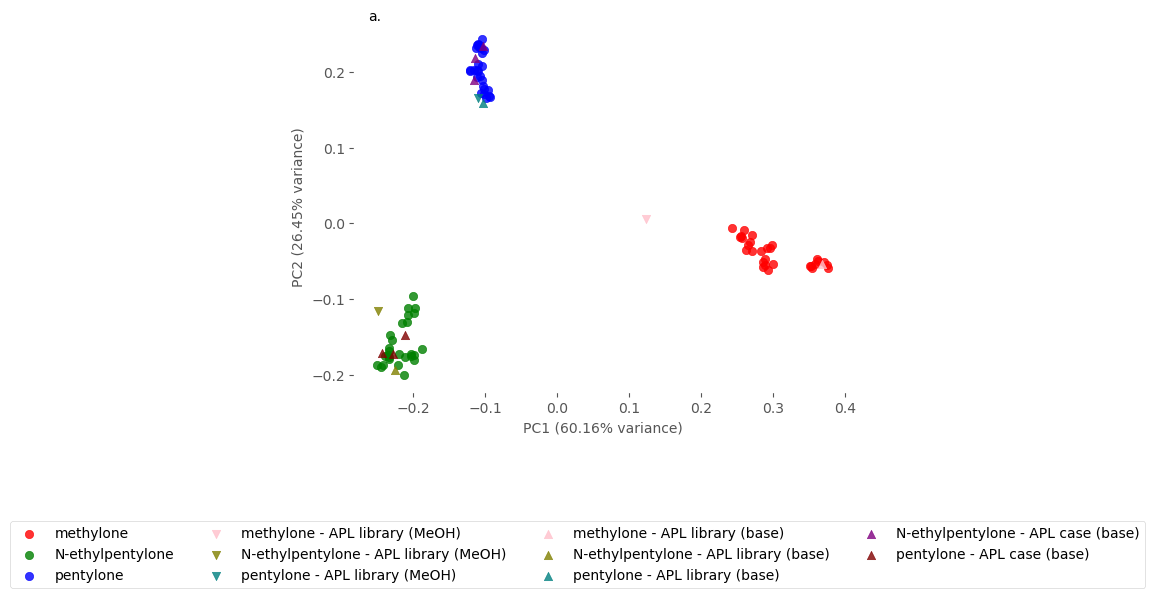

In [38]:
label_test_base = pd.read_pickle("label_test_base.pkl")
labels_test_base = sorted(np.unique(label_test_base), key=str.casefold)

label_test_meoh = pd.read_pickle("label_test_meoh.pkl")
labels_test_meoh = sorted(np.unique(label_test_meoh), key=str.casefold)

label_primary = pd.read_pickle("label_primary.pkl")
labels_primary = sorted(np.unique(label_primary), key=str.casefold)

data_primary = pd.read_pickle("data_primary.pkl") #2 weeks of training
data_test_meoh = pd.read_pickle("data_test_meoh.pkl") #test not Others
data_test_base = pd.read_pickle("data_test_base.pkl") #test not Others

mahal_test_meoh = pd.DataFrame(columns = ('methylone', 'N-ethylpentylone', 'pentylone'), index = data_test_meoh.index)
mahal_test_base = pd.DataFrame(columns = ('methylone', 'N-ethylpentylone', 'pentylone'), index = data_test_base.index)
   
data_list = list((data_primary, data_test_meoh, data_test_base))
for dat in range(0,3):
    data_list[dat] = baseline(data_list[dat], type = "second_deriv")

pca = PCA(n_components=5)    #set to perform PCA 
data_primary, data_test_meoh, data_test_base = data_list

np.random.seed(7)                 #set random seed
pca.fit(data_primary)

pc1 = np.round(pca.explained_variance_ratio_[0] * 100, 2)  # calculate pca variances
pc2 = np.round(pca.explained_variance_ratio_[1] * 100, 2)

#PCA plot
data_plot = pca.transform(data_primary)
plot_test_meoh = pca.transform(data_test_meoh)
plot_test_base = pca.transform(data_test_base)

colors = ['r', 'g', 'b']
target_names = ['methylone','N-ethylpentylone','pentylone']
legend = dict(zip(colors, target_names))

target_test_base = ['methylone - APL library (base)', 'N-ethylpentylone - APL library (base)', 'pentylone - APL library (base)', 'N-ethylpentylone - APL case (base)', 'pentylone - APL case (base)'] 
target_test_meoh = ['methylone - APL library (MeOH)', 'N-ethylpentylone - APL library (MeOH)', 'pentylone - APL library (MeOH)'] 

colors_test_base = ['pink', 'olive', 'teal', 'purple', 'maroon']
colors_test_meoh = ['pink', 'olive', 'teal']

#Mahalanobis distance
for cmpd in range(0,3):
    mahal_test_meoh.iloc[:,cmpd] = mahalanobis(plot_test_meoh[:,0:3], data_plot[label_primary == labels_primary[cmpd],0:3])
    mahal_test_base.iloc[:,cmpd] = mahalanobis(plot_test_base[:,0:3], data_plot[label_primary == labels_primary[cmpd],0:3])

mahal_test_meoh.to_excel(f'Mahalanobis_test_meoh.xlsx')
mahal_test_base.to_excel(f'Mahalanobis_test_base.xlsx')

fig = plt.figure()
ax = plt.axes()

for color, z, target_name in zip(colors, labels_primary, target_names):
    ax.scatter(data_plot[label_primary == z, 0], data_plot[label_primary == z, 1], alpha=.8, color=color,
                label=target_name, marker = "o")  # plot training set
    
for color, z, target_name in zip(colors_test_meoh, labels_test_meoh, target_test_meoh):
    ax.scatter(plot_test_meoh[label_test_meoh == z, 0], plot_test_meoh[label_test_meoh == z, 1], alpha=.8, color=color, marker = 'v', label=target_name)

for color, z, target_name in zip(colors_test_base, labels_test_base, target_test_base):
    ax.scatter(plot_test_base[label_test_base == z, 0], plot_test_base[label_test_base == z, 1], alpha=.8, color=color, marker = '^', label=target_name)

plt.legend(bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=4, shadow=False, scatterpoints=1)  # plot legend
plt.xlabel(f'PC1 ({pc1}% variance)', fontsize = 10)
plt.ylabel(f'PC2 ({pc2}% variance)', fontsize = 10)
text_x = min(data_plot[:,0])*1.05
text_y = max(data_plot[:,1])*1.1
plt.text(text_x, text_y, 'a.')
# plt.savefig(f'APL_PCA_second_test.pdf', dpi = 600)
plt.show()

## PCA - weeks

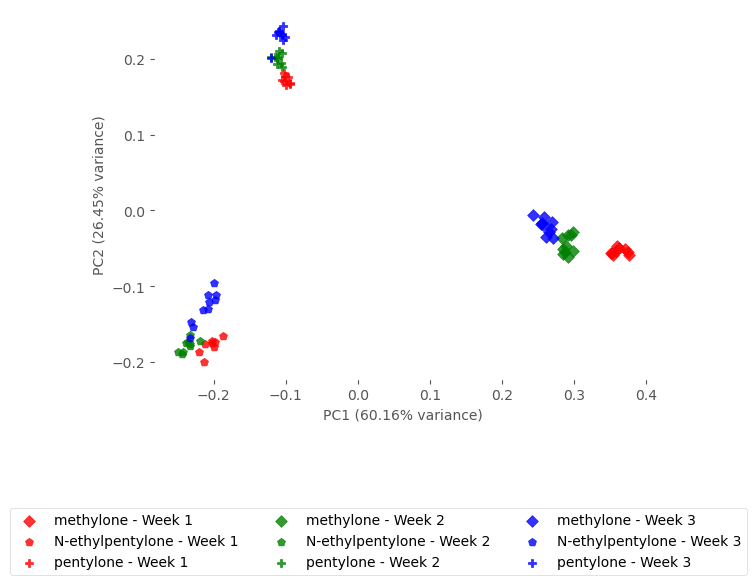

In [26]:
#Load label vectors and create arrays of sorted unique labels
label_train = pd.read_pickle("label_train.pkl")
labels = sorted(np.unique(label_train), key=str.casefold)

label_val1 = pd.read_pickle("label_val1.pkl")
labels_val1 = sorted(np.unique(label_val1), key=str.casefold)

label_val2 = pd.read_pickle("label_val2.pkl")
labels_val2 = sorted(np.unique(label_val2), key=str.casefold)

label_primary = pd.read_pickle("label_primary.pkl")
labels_primary = sorted(np.unique(label_primary), key=str.casefold)

data_primary = pd.read_pickle("data_primary.pkl") #2 weeks of training
data_train = pd.read_pickle("data_train.pkl") #test not Others
data_val1 = pd.read_pickle("data_val1.pkl") #test not Others
data_val2 = pd.read_pickle("data_val2.pkl") #test not Others

data_list = list((data_primary, data_train, data_val1, data_val2))
for dat in range(0,4):
    data_list[dat] = baseline(data_list[dat], type = "second_deriv")

data_primary, data_train, data_val1, data_val2 = data_list

pca = PCA(n_components=5)    #set to perform PCA 
np.random.seed(7)                 #set random seed
pca.fit(data_primary)

pc1 = np.round(pca.explained_variance_ratio_[0] * 100, 2)  # calculate pca variances
pc2 = np.round(pca.explained_variance_ratio_[1] * 100, 2)

#PCA plot
plot_train = pca.transform(data_train)
plot_val1 = pca.transform(data_val1)
plot_val2 = pca.transform(data_val2)

target_names = ['methylone - Week 1','N-ethylpentylone - Week 1','pentylone - Week 1']
target_val1 = ('methylone - Week 2', 'N-ethylpentylone - Week 2', 'pentylone - Week 2')
target_val2 = ('methylone - Week 3', 'N-ethylpentylone - Week 3', 'pentylone - Week 3')
markers = ('D', 'p', 'P')

fig = plt.figure()
ax = plt.axes()

for marker, z, target_name in zip(markers, labels, target_names):
    ax.scatter(plot_train[label_train == z, 0], plot_train[label_train == z, 1], alpha=.8, color='r',
                label=target_name, marker = marker)  # plot training set
    
for marker, z, target_name in zip(markers, labels_val1, target_val1):
    ax.scatter(plot_val1[label_val1 == z, 0], plot_val1[label_val1 == z, 1], alpha=.8, color='g',
                label=target_name, marker = marker)  # plot training set

for marker, z, target_name in zip(markers, labels_val2, target_val2):
    ax.scatter(plot_val2[label_val2 == z, 0], plot_val2[label_val2 == z, 1], alpha=.8, color='b',
                label=target_name, marker = marker)  # plot training set

plt.legend(bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=3, shadow=False, scatterpoints=1)  # plot legend
plt.xlabel(f'PC1 ({pc1}% variance)', fontsize = 10)
plt.ylabel(f'PC2 ({pc2}% variance)', fontsize = 10)
plt.savefig(f'APL_PCA_second_byweek.pdf', dpi = 600)
plt.show()


## PCA - Others

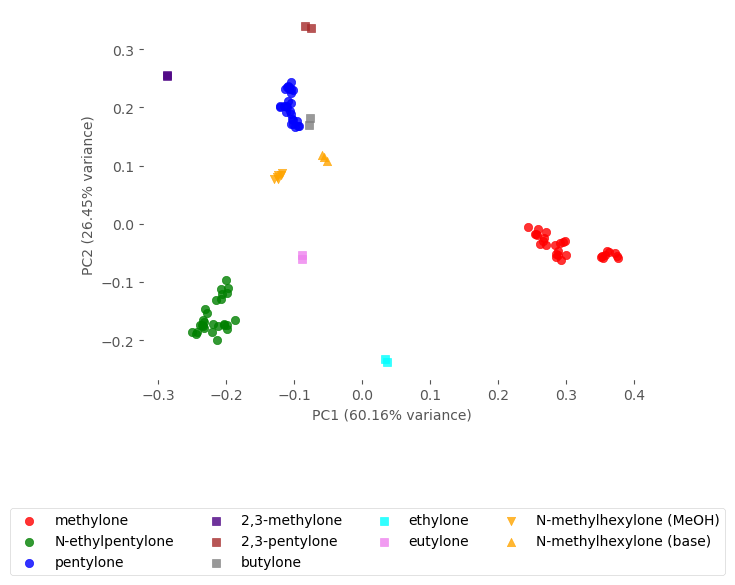

In [40]:
#Load label vectors and create arrays of sorted unique labels
label_other = pd.read_pickle("label_other.pkl")
labels_other = sorted(np.unique(label_other), key=str.casefold)

label_primary = pd.read_pickle("label_primary.pkl")
labels_primary = sorted(np.unique(label_primary), key=str.casefold)

data_primary = pd.read_pickle("data_primary.pkl") #2 weeks of training
data_other = pd.read_pickle("data_other.pkl") #test not Others

mahal_other = pd.DataFrame(columns = ('methylone', 'N-ethylpentylone', 'pentylone'), index = data_other.index)

data_list = list((data_primary, data_other))
for dat in range(0,2):
    data_list[dat] = baseline(data_list[dat], type = "second_deriv")

data_primary, data_other = data_list

pca = PCA(n_components=5)    #set to perform PCA 
np.random.seed(7)                 #set random seed
pca.fit(data_primary)

pc1 = np.round(pca.explained_variance_ratio_[0] * 100, 2)  # calculate pca variances
pc2 = np.round(pca.explained_variance_ratio_[1] * 100, 2)

#PCA plot
data_plot = pca.transform(data_primary)
plot_other = pca.transform(data_other)

colors = ['r', 'g', 'b']
target_names = ['methylone','N-ethylpentylone','pentylone']

target_other = ('2,3-methylone', '2,3-pentylone', 'butylone', 'ethylone', 'eutylone', 'N-methylhexylone (MeOH)', 'N-methylhexylone (base)')
color_other = ('indigo', 'brown', 'gray', 'cyan', 'violet', 'orange', 'orange')
markers = ('s', 's', 's', 's', 's', 'v', '^')

fig = plt.figure()
ax = plt.axes()

for color, z, target_name in zip(colors, labels_primary, target_names):
    ax.scatter(data_plot[label_primary == z, 0], data_plot[label_primary == z, 1], alpha=.8, color=color,
                label=target_name, marker = "o")  # plot training set
    
for marker, color, z, target_name in zip(markers, color_other, labels_other, target_other):
    ax.scatter(plot_other[label_other == z, 0], plot_other[label_other == z, 1], alpha=.8, color=color,
                label=target_name, marker = marker)  # plot training set

plt.legend(bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=4, shadow=False, scatterpoints=1)  # plot legend
plt.xlabel(f'PC1 ({pc1}% variance)', fontsize = 10)
plt.ylabel(f'PC2 ({pc2}% variance)', fontsize = 10)
# plt.savefig(f'APL_PCA_second_other.pdf', dpi = 600)
plt.show()

for cmpd in range(0,3):
    mahal_other.iloc[:,cmpd] = mahalanobis(plot_other[:,0:3], data_plot[label_primary == labels_primary[cmpd],0:3])

mahal_other.to_excel(f'Mahalanobis_other3.xlsx')
